# Pipeline for High-z Radio Galaxies 03: Radio detection classification with confirmed AGN

## Introduction

Training for classification of sources with and without radio detection in the HETDEX field. 

Sources are all elements detected in the CatWISE2020 catalogue.  But classification  
will be done with AGN from the Million Quasar Catalog (MQC) and those predicted  
to be AGN by the initial Galaxy/AGN classification model (`ML_01.ipynb`).  

Being either AGN or galaxy will be used as an additional feature.

Training data is from HETDEX Spring Field.

In [1]:
%matplotlib inline
# Static plots
#%matplotlib ipympl
# Interactive plots
import numpy as np
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patheffects as mpe
from astropy.visualization import LogStretch, PowerStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, roc_auc_score, roc_curve, RocCurveDisplay, brier_score_loss
from sklearn.metrics import matthews_corrcoef, precision_recall_curve, PrecisionRecallDisplay, auc
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
import sklearn.pipeline
from betacal import BetaCalibration
import ppscore as pps
import seaborn as sns
import colorcet as cc
from pycaret import classification as pyc
from joblib import dump, load
import pandas as pd
import global_variables as gv
import global_functions as gf

In [2]:
mpl.rcdefaults()

In [3]:
plt.rcParams['text.usetex'] = True

***

## Reading data

We import our data using the `pandas` package.

In [4]:
save_plot_flag         = False
save_model_flag        = False
use_AGN_gal_model_flag = False
load_model_flag        = True
use_calibration        = True

First, open the file as astropy Table to modify (and standardise)  
the units of fluxes and/or magnitudes.

---

Create `pandas` DataFrame from `astropy` table.

In [5]:
features_2_discard = ['objID', 'RA_ICRS', 'DE_ICRS', 'Name', 'RA_MILLI', 'DEC_MILLI',\
                     'TYPE', 'Z', 'zsp', 'X_ray_detect', 'Total_flux_VLASS', 'Sint_LOFAR',\
                      'Stotal_TGSS', 'FEP', 'TotalFlux_LoLSS', 'W1mag', 'W2mag', 'spCl',\
                      'FUVmag', 'NUVmag', 'num_imputed', 'radio_detect', 'TGSS_detect',\
                      'VLASS_detect', 'LoLSS_detect'] # , 'mode',\
                     # 'class', 'f_zsp', 'subCl', 'zph', 'e_zph']  # Not needed for training in this model

In [6]:
full_catalog_df = pd.read_hdf(gv.cat_path + gv.file_HETDEX, key='df').drop(columns=features_2_discard)

In [7]:
# full_catalog_df.describe()

#### Load previous model to create labels for unknown sources (in general, do not use this).

In [8]:
confirmed_indices = full_catalog_df.loc[(full_catalog_df.loc[:, 'is_gal'] == 1) | (full_catalog_df.loc[:, 'is_AGN'] == 1)].index
unknown_indices   = full_catalog_df.drop(index=confirmed_indices).index
final_indices     = confirmed_indices.union(unknown_indices)  # all

In [9]:
print(f'There are {np.sum(full_catalog_df.loc[:, "is_AGN"] == 1):,} confirmed AGN in this dataset.')

There are 28,251 confirmed AGN in this dataset.


In [10]:
if use_AGN_gal_model_flag:
    AGN_gal_clf = pyc.load_model(gv.models_path + gv.AGN_gal_model)  # From ML_16.ipynb

In [11]:
if use_AGN_gal_model_flag:
    new_labels_train   = pyc.predict_model(AGN_gal_clf, data=full_catalog_df,\
                                           probability_threshold=gv.AGN_thresh,\
                                           raw_score=True).loc[:, 'Score_1']

In [12]:
if use_AGN_gal_model_flag:
    full_catalog_df['class'] = new_labels_train.copy()

In [13]:
if use_AGN_gal_model_flag:
    full_catalog_df.loc[:, 'class'] = full_catalog_df.loc[:, 'class'].mask(full_catalog_df.loc[:, 'is_gal'] == 1, 0)
    full_catalog_df.loc[:, 'class'] = full_catalog_df.loc[:, 'class'].mask(full_catalog_df.loc[:, 'is_AGN'] == 1, 1)

#### Select only confirmed and highly likely AGN

In [14]:
if use_AGN_gal_model_flag:
    AGN_threshold = 0.95
    gal_threshold = 0.05

In [15]:
if use_AGN_gal_model_flag:
    filter_upgrade_AGN = (full_catalog_df.loc[:, 'class'] > AGN_threshold) & (full_catalog_df.loc[:, 'class'] < 1.00)
    filter_upgrade_gal = (full_catalog_df.loc[:, 'class'] < gal_threshold) & (full_catalog_df.loc[:, 'class'] > 0.00)
    full_catalog_df.loc[:, 'class'] = full_catalog_df.loc[:, 'class'].mask(filter_upgrade_AGN, 1)
    full_catalog_df.loc[:, 'class'] = full_catalog_df.loc[:, 'class'].mask(filter_upgrade_gal, 0)

In [16]:
if not use_AGN_gal_model_flag:
    full_catalog_df.loc[:, 'class'] = full_catalog_df.loc[:, 'is_AGN'].copy()

In [17]:
full_catalog_df.loc[:, 'class'] = full_catalog_df.loc[:, 'class'].astype(int)

In [18]:
target_feat = 'LOFAR_detect'

## Possible correlations

In [19]:
print(full_catalog_df.columns.to_list())

['band_num', 'LOFAR_detect', 'is_str', 'is_SDSS_QSO', 'is_AGN', 'is_SDSS_gal', 'is_gal', 'W1mproPM', 'W2mproPM', 'gmag', 'rmag', 'imag', 'zmag', 'ymag', 'Jmag', 'Hmag', 'Kmag', 'W3mag', 'W4mag', 'g_r', 'g_i', 'g_z', 'g_y', 'g_J', 'g_H', 'g_K', 'g_W1', 'g_W2', 'g_W3', 'g_W4', 'r_i', 'r_z', 'r_y', 'r_J', 'r_H', 'r_K', 'r_W1', 'r_W2', 'r_W3', 'r_W4', 'i_z', 'i_y', 'i_J', 'i_H', 'i_K', 'i_W1', 'i_W2', 'i_W3', 'i_W4', 'z_y', 'z_J', 'z_H', 'z_K', 'z_W1', 'z_W2', 'z_W3', 'z_W4', 'y_J', 'y_H', 'y_K', 'y_W1', 'y_W2', 'y_W3', 'y_W4', 'J_H', 'J_K', 'J_W1', 'J_W2', 'J_W3', 'J_W4', 'H_K', 'H_W1', 'H_W2', 'H_W3', 'H_W4', 'K_W1', 'K_W2', 'K_W3', 'K_W4', 'W1_W2', 'W1_W3', 'W1_W4', 'W2_W3', 'W2_W4', 'W3_W4', 'class']


---

Create target

In [20]:
full_catalog_df.loc[:, target_feat] = full_catalog_df.loc[:, target_feat].astype(int)

## Split data: Test, Train, Validation

Create same train/test/validation sub-sets as with AGN/galaxy model.  
After this, select sources needed for this model (`class == 1`)

In [21]:
filter_known_spec = (full_catalog_df.loc[:, 'is_AGN'] == 1) | (full_catalog_df.loc[:, 'is_gal'] == 1)
full_catalog_df   = full_catalog_df.loc[filter_known_spec]
train_test_df, train_df, test_df, calibration_df, validation_df = gf.split_set(full_catalog_df, [0.2, 0.2, 0.5],\
                                                                               'class', use_calibration=use_calibration)
print('Shape of used data in HETDEX')
print('-' * 60)
print(f'Full confirmed dataset size:                      {full_catalog_df.shape}')
print(f'Data for Modeling (Train, Test, and Calibration): {train_test_df.shape}')
print(f'Training data:                                    {train_df.shape}')
print(f'Testing data:                                     {test_df.shape}')
if use_calibration:
    print(f'Calibration data:                                 {calibration_df.shape}')
print(f'Validation data:                                  {validation_df.shape}')
print('-' * 60)
print()

Shape of used data in HETDEX
------------------------------------------------------------
Full confirmed dataset size:                      (83409, 86)
Data for Modeling (Train, Test, and Calibration): (66727, 86)
Training data:                                    (53381, 86)
Testing data:                                     (6673, 86)
Calibration data:                                 (6673, 86)
Validation data:                                  (16682, 86)
------------------------------------------------------------



In [22]:
full_catalog_df = full_catalog_df.loc[(full_catalog_df.loc[:, 'class'] == 1)]
train_test_df   = train_test_df.loc[(train_test_df.loc[:, 'class'] == 1)]
train_df        = train_df.loc[(train_df.loc[:, 'class'] == 1)]
test_df         = test_df.loc[(test_df.loc[:, 'class'] == 1)]
calibration_df  = calibration_df.loc[(calibration_df.loc[:, 'class'] == 1)]
validation_df   = validation_df.loc[(validation_df.loc[:, 'class'] == 1)]

In [23]:
n_is_AGN = np.sum(full_catalog_df.loc[:, 'class'] == 1)
n_is_rad = np.sum(full_catalog_df.loc[:, target_feat] == 1)
print(f'In this dataset (HETDEX), with {len(full_catalog_df.loc[:, "is_AGN"]):,} elements,\n' +\
         f'{n_is_AGN:,} of them are marked as AGN, and, from them, {n_is_rad:,} have confirmed radio detection.')

In this dataset (HETDEX), with 28,251 elements,
28,251 of them are marked as AGN, and, from them, 8,339 have confirmed radio detection.


Remove intermediate targets

In [24]:
cols_to_discard_classes = ['is_AGN', 'is_SDSS_QSO', 'is_SDSS_gal', 'is_gal', 'class', 'is_str']
full_catalog_df = full_catalog_df.drop(columns=cols_to_discard_classes)
train_test_df   = train_test_df.drop(columns=cols_to_discard_classes)
train_df        = train_df.drop(columns=cols_to_discard_classes)
test_df         = test_df.drop(columns=cols_to_discard_classes)
calibration_df  = calibration_df.drop(columns=cols_to_discard_classes)
validation_df   = validation_df.drop(columns=cols_to_discard_classes)

---

In [25]:
print('Final shape of used data')
print('-' * 65)
print('(Confirmed AGN)')
print('-' * 50)
print(f'Full confirmed dataset size:        {full_catalog_df.shape}')
print(f'Data for Modeling (Train and Test): {train_test_df.shape}')
print(f'Training data:                      {train_df.shape}')
print(f'Testing data:                       {test_df.shape}')
print(f'Calibration data:                   {calibration_df.shape}')
print(f'Validation data:                    {validation_df.shape}')
print('-' * 65)

Final shape of used data
-----------------------------------------------------------------
(Confirmed AGN)
--------------------------------------------------
Full confirmed dataset size:        (28251, 80)
Data for Modeling (Train and Test): (22601, 80)
Training data:                      (18081, 80)
Testing data:                       (2260, 80)
Calibration data:                   (2260, 80)
Validation data:                    (5650, 80)
-----------------------------------------------------------------


---

## Use Correlation matrix to discard some features

In [26]:
min_max_scaler              = MinMaxScaler(feature_range=(0., 1.))
full_scaled                 = min_max_scaler.fit_transform(train_test_df.values)
norm_train_test_df = pd.DataFrame(data=full_scaled, columns=train_test_df.columns, index=train_test_df.index)

Calculate Reduced Standard deviation to discard between pairs of features:  

$$\mathrm{RSD} = \frac{\sigma}{\mu} \times 100$$

In [27]:
rsd_vals = (train_test_df.std() / train_test_df.mean() * 100).sort_values(ascending=False)

In [28]:
rsd_vals

K_W3            624.424131
z_y             516.256644
i_z             326.853578
i_y             237.564569
r_i             173.388802
LOFAR_detect    153.715588
r_y             144.427476
g_r             144.193405
r_z             143.625234
g_i             112.576827
g_y             107.516920
g_z             104.764871
W1_W2            91.869769
y_W1             67.729441
z_W1             59.368716
H_W3             58.563533
i_W1             53.996987
r_W1             52.870262
g_W1             52.824714
y_W2             52.603153
z_W2             45.878199
J_W3             45.081374
i_W2             41.339035
y_J              40.973477
g_W2             40.358603
r_W2             40.235013
y_H              37.844857
z_J              37.588309
i_J              35.690666
z_H              34.812818
W2_W3            34.482810
r_J              34.098272
i_H              33.172435
y_K              32.440916
W1_W3            32.249316
g_J              32.095223
r_H              31.849533
g

In [29]:
correlation    = norm_train_test_df.corr()

In [30]:
filt_high_corr = np.array(correlation.abs().unstack().sort_values(ascending=False).drop_duplicates().values > 0.75) &\
np.array(correlation.abs().unstack().sort_values(ascending=False).drop_duplicates().values < 1.00)

In [31]:
corr_pairs     = correlation.abs().unstack().sort_values(ascending=False).drop_duplicates().index[filt_high_corr]

In [32]:
list_drop_corr = []

We want to discard features that are highly correlated (>0.75).  
Between two features, we will discard the one with the lowest standard deviation (RSD).

In [33]:
for row in corr_pairs:
    if target_feat in row:
        continue
    elif row[0] in list_drop_corr:
        continue
    elif row[1] in list_drop_corr:
        continue
    else:
        metric_a = rsd_vals[row[0]]
        metric_b = rsd_vals[row[1]]
        if metric_a >= metric_b:
            list_drop_corr.append(row[1])
        else:
            list_drop_corr.append(row[0])

In [34]:
list_drop_corr

['y_H',
 'g_H',
 'r_H',
 'z_H',
 'i_H',
 'J_W1',
 'J_W2',
 'y_K',
 'J_W3',
 'z_K',
 'i_K',
 'r_K',
 'g_K',
 'H_W1',
 'H_W2',
 'Jmag',
 'J_W4',
 'K_W1',
 'K_W2',
 'ymag',
 'zmag',
 'W1mproPM',
 'imag',
 'rmag',
 'gmag',
 'W2mproPM',
 'y_W4',
 'g_W4',
 'r_W4',
 'z_W4',
 'i_W4',
 'W1_W4',
 'Kmag',
 'W2_W4',
 'H_W3',
 'r_J',
 'g_W2',
 'J_K',
 'W1_W3',
 'r_W3',
 'i_J',
 'y_W3',
 'r_W2',
 'i_W3',
 'g_W3',
 'z_W3',
 'y_W2',
 'z_W2',
 'i_W2',
 'g_W1',
 'r_W1',
 'H_W4',
 'W3mag',
 'z_J',
 'Hmag',
 'i_W1',
 'g_y',
 'W3_W4',
 'r_y',
 'g_z',
 'g_J',
 'g_i']

In [35]:
# correlation.abs().unstack().sort_values(ascending=False).drop_duplicates()[:15]

In [36]:
norm_train_test_discard = norm_train_test_df.drop(columns=list_drop_corr)

In [37]:
corr_discard = norm_train_test_discard.corr()

In [38]:
corr_discard.abs().unstack().sort_values(ascending=False).drop_duplicates()[:15]

band_num  band_num    1.000000
z_y       i_y         0.737201
y_J       W2_W3       0.736708
band_num  y_J         0.728645
z_W1      y_W1        0.719265
W4mag     K_W3        0.688022
i_z       r_z         0.671493
K_W3      K_W4        0.636035
W2_W3     band_num    0.610033
r_i       r_z         0.571296
W4mag     K_W4        0.568049
K_W3      y_J         0.517616
band_num  H_K         0.485582
y_J       y_W1        0.467664
W1_W2     H_K         0.454817
dtype: float64

Text(1052.0930609538775, 0.5, 'feature')

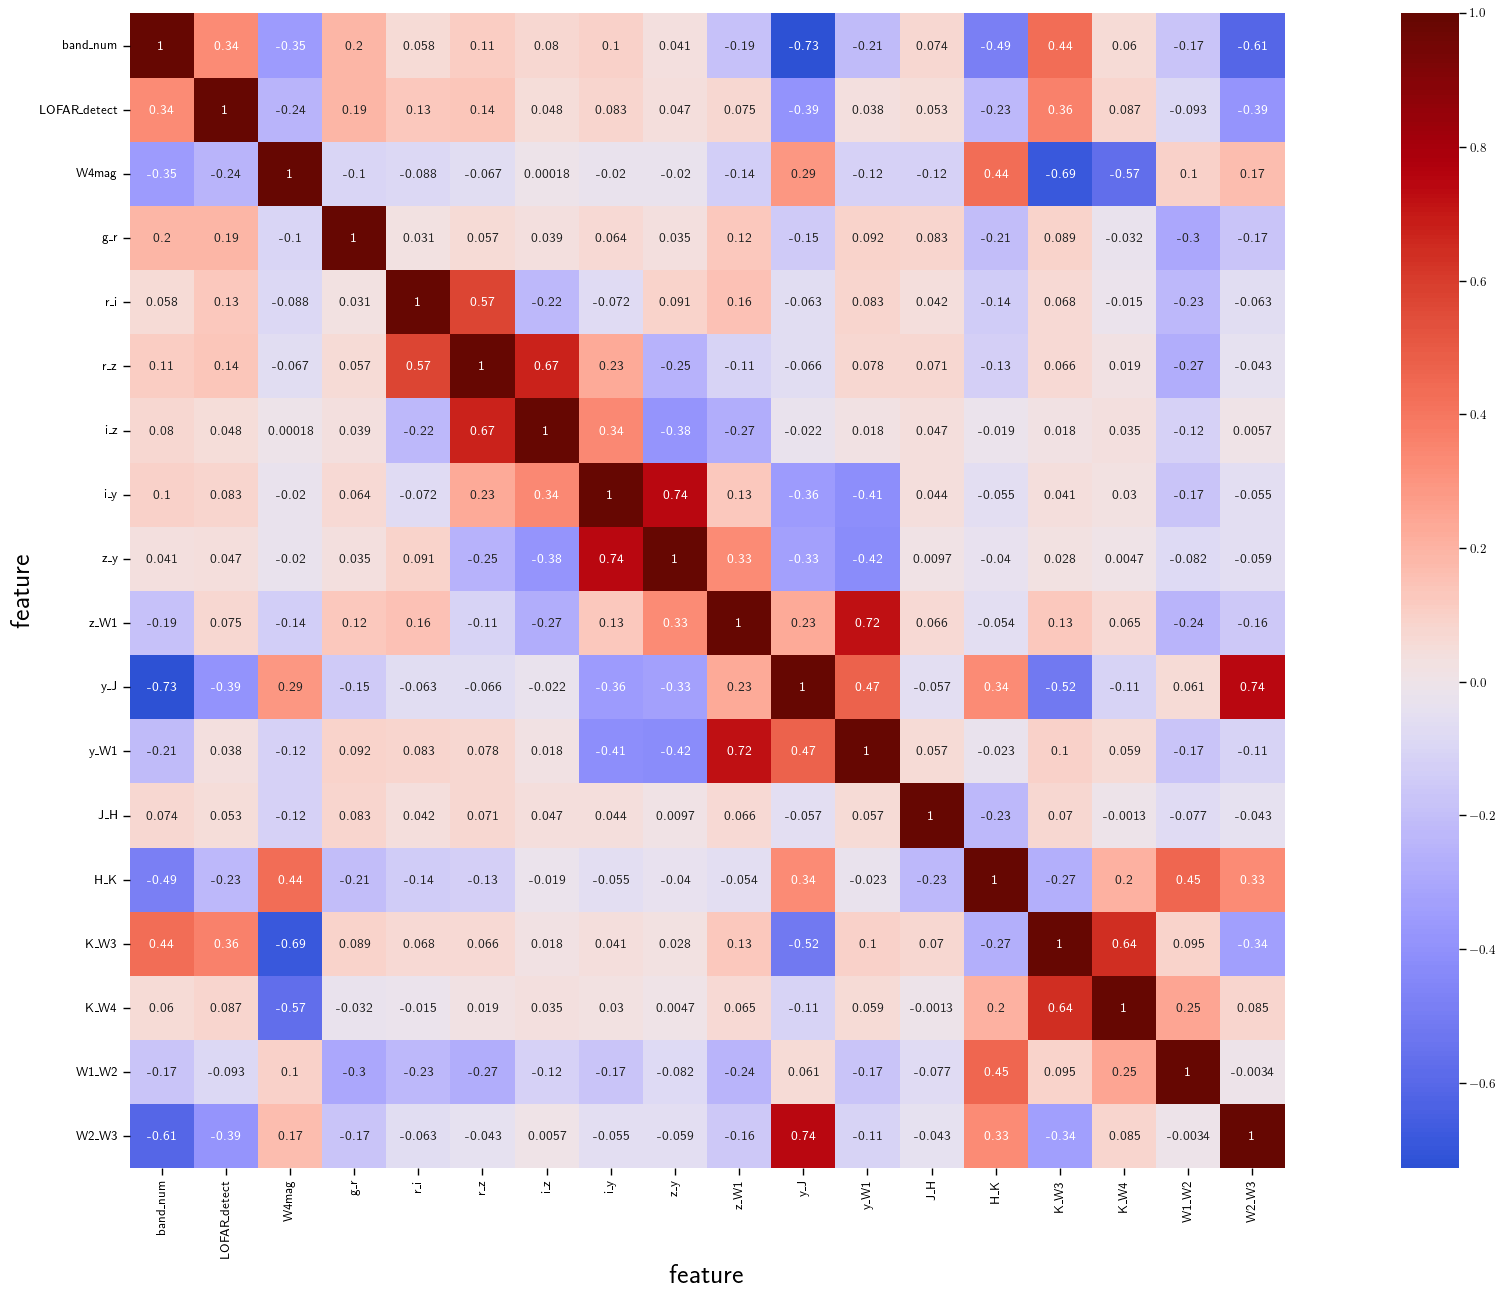

In [39]:
plt.figure(figsize=(30,15))
sns.set_context('paper', rc={'axes.labelsize':20, 'axes.ticklabelsize':14})
ax1 = sns.heatmap(corr_discard, annot=True, cmap=plt.get_cmap('cet_CET_D1A'), center=0.0, square=True)
ax1.set_xlabel('feature')
ax1.set_ylabel('feature')

In [40]:
norm_train_test_discard.loc[:, target_feat] = norm_train_test_discard.loc[:, target_feat].astype(bool)

In [41]:
pps_matrix = pps.matrix(norm_train_test_discard, random_seed=gv.seed)[['x', 'y', 'ppscore']].pivot(columns='x', index='y', values='ppscore')

In [42]:
pps_matrix.unstack().sort_values(ascending=False).drop_duplicates()[:20]

x         y           
H_K       H_K             1.000000
band_num  y_J             0.583463
K_W4      W4mag           0.479233
J_H       H_K             0.377591
band_num  z_y             0.326286
K_W3      LOFAR_detect    0.319158
band_num  W2_W3           0.295017
z_y       i_y             0.278370
y_J       band_num        0.263354
z_y       y_J             0.243914
band_num  LOFAR_detect    0.238572
K_W4      LOFAR_detect    0.238428
y_J       LOFAR_detect    0.229624
K_W3      W4mag           0.226845
y_W1      z_W1            0.220211
band_num  i_y             0.220024
W2_W3     y_J             0.214692
W4mag     LOFAR_detect    0.214232
K_W3      W2_W3           0.211814
y_J       W2_W3           0.209362
dtype: float64

In [43]:
filt_high_pps = np.array(pps_matrix.abs().unstack().sort_values(ascending=False).drop_duplicates().values > 0.75) &\
np.array(pps_matrix.abs().unstack().sort_values(ascending=False).drop_duplicates().values < 1.00)

In [44]:
pps_pairs     = pps_matrix.abs().unstack().sort_values(ascending=False).drop_duplicates().index[filt_high_pps]

In [45]:
list_drop_pps = []

In [46]:
for row in pps_pairs:
    if target_feat in row:
        continue
    elif row[0] in list_drop_pps:
        continue
    elif row[1] in list_drop_pps:
        continue
    else:
        metric_a = rsd_vals[row[0]]
        metric_b = rsd_vals[row[1]]
        if metric_a >= metric_b:
            list_drop_pps.append(row[1])
        else:
            list_drop_pps.append(row[0])

In [47]:
list_drop_pps

[]

In [48]:
norm_train_test_discard = norm_train_test_discard.drop(columns=list_drop_pps)

In [49]:
pps_pred_target = pps.predictors(norm_train_test_discard, target_feat, random_seed=gv.seed)

In [50]:
pps_pred_target

,x,y,ppscore,case,is_valid_score,metric,baseline_score,model_score,model
0,K_W3,LOFAR_detect,0.319158,classification,True,weighted F1,0.5936,0.723306,DecisionTreeClassifier()
1,band_num,LOFAR_detect,0.238572,classification,True,weighted F1,0.5936,0.690556,DecisionTreeClassifier()
2,K_W4,LOFAR_detect,0.238428,classification,True,weighted F1,0.5936,0.690497,DecisionTreeClassifier()
3,y_J,LOFAR_detect,0.229624,classification,True,weighted F1,0.5936,0.686919,DecisionTreeClassifier()
4,W4mag,LOFAR_detect,0.214232,classification,True,weighted F1,0.5936,0.680664,DecisionTreeClassifier()
5,W2_W3,LOFAR_detect,0.208734,classification,True,weighted F1,0.5936,0.678430,DecisionTreeClassifier()
6,J_H,LOFAR_detect,0.160816,classification,True,weighted F1,0.5936,0.658956,DecisionTreeClassifier()
7,H_K,LOFAR_detect,0.157208,classification,True,weighted F1,0.5936,0.657489,DecisionTreeClassifier()
8,W1_W2,LOFAR_detect,0.133430,classification,True,weighted F1,0.5936,0.647826,DecisionTreeClassifier()
9,r_i,LOFAR_detect,0.088823,classification,True,weighted F1,0.5936,0.629698,DecisionTreeClassifier()


In [51]:
print(f'{len(full_catalog_df):,}')

28,251


---

## Use Machine Learning (ML): PyCaret

## Train Models

### AGN Detection Prediction

In [52]:
final_feats = pps_pred_target.x.to_list()  # Before Boruta

In [53]:
feats_2_discard = list_drop_corr + list_drop_pps

Boruta discards no features.

In [54]:
exp_radio = pyc.setup(data=train_df, test_data=test_df, target=target_feat, session_id=gv.seed, silent=True,\
                      feature_selection=False, feature_selection_method='boruta', data_split_stratify=True,\
                      numeric_features=final_feats, ignore_features=feats_2_discard, transformation=True,\
                      transformation_method='yeo-johnson', n_jobs=12, normalize=True,\
                      normalize_method='zscore', use_gpu=False)  # 15 minutes with Boruta # 5 without

,Description,Value
0,session_id,42
1,Target,LOFAR_detect
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(18081, 80)"
5,Missing Values,False
6,Numeric Features,17
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


In [54]:
pyc.get_config('X').columns

Index(['band_num', 'W4mag', 'g_r', 'r_i', 'r_z', 'i_z', 'i_y', 'z_y', 'z_W1',
       'y_J', 'y_W1', 'J_H', 'H_K', 'K_W3', 'K_W4', 'W1_W2', 'W2_W3'],
      dtype='object')

In [55]:
pyc.models()

,Name,Reference,Turbo
ID,,,
lr,Logistic Regression,sklearn.linear_model._logistic.LogisticRegression,True
knn,K Neighbors Classifier,sklearn.neighbors._classification.KNeighborsCl...,True
nb,Naive Bayes,sklearn.naive_bayes.GaussianNB,True
dt,Decision Tree Classifier,sklearn.tree._classes.DecisionTreeClassifier,True
svm,SVM - Linear Kernel,sklearn.linear_model._stochastic_gradient.SGDC...,True
rbfsvm,SVM - Radial Kernel,sklearn.svm._classes.SVC,False
gpc,Gaussian Process Classifier,sklearn.gaussian_process._gpc.GaussianProcessC...,False
mlp,MLP Classifier,sklearn.neural_network._multilayer_perceptron....,False
ridge,Ridge Classifier,sklearn.linear_model._ridge.RidgeClassifier,True


Add F_beta score ($\beta = 1.1$).

In [56]:
pyc.add_metric('f_beta', 'F_score', gf.f_beta, greater_is_better=True)

Name                                             F_score
Display Name                                     F_score
Score Function       <function f_beta at 0x7fb521b24280>
Scorer                               make_scorer(f_beta)
Target                                              pred
Args                                                  {}
Greater is Better                                   True
Multiclass                                          True
Custom                                              True
Name: f_beta, dtype: object

In [57]:
metric_2_sort         = 'Recall'
final_selection_clf   = ['rf', 'catboost', 'xgboost', 'et', 'gbc', 'dummy']  # lightgbm is selected to be base learner.
initial_selection_clf = ['rf', 'gbc', 'et', 'xgboost', 'catboost', 'dummy']  # Only tree-based models (except lightgbm,dt)
n_models              = 5
top_model_radio = pyc.compare_models(n_select=n_models, include=final_selection_clf, sort=metric_2_sort)  # 1:15 hour for used_models_clf
# top_model_radio = pyc.compare_models(n_select=n_models, include=initial_selection_clf, sort=metric_2_sort)  # 10 minutes, using all models.

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,F_score,TT (Sec)
xgboost,Extreme Gradient Boosting,0.7730,0.7904,0.4848,0.6657,0.5610,0.4130,0.4225,0.5527,8.7020
catboost,CatBoost Classifier,0.7851,0.8091,0.4830,0.7061,0.5735,0.4365,0.4507,0.5634,1.2150
rf,Random Forest Classifier,0.7799,0.8007,0.4787,0.6912,0.5654,0.4245,0.4375,0.5558,0.6370
et,Extra Trees Classifier,0.7784,0.7969,0.4680,0.6919,0.5581,0.4175,0.4319,0.5480,0.1380
gbc,Gradient Boosting Classifier,0.7803,0.8040,0.4567,0.7054,0.5544,0.4174,0.4348,0.5433,0.6540
dummy,Dummy Classifier,0.7008,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0150


Thus, we will select `catboost` as meta learner.

Thus, we stack the models.

In [60]:
# stacked_model_radio = pyc.stack_models(estimator_list=top_model_radio[1:], meta_model=top_model_radio[0],\
#                                        optimize=metric_2_sort, restack=True)
stacked_model_radio = pyc.stack_models(estimator_list=top_model_radio[0:1] + top_model_radio[2:],\
                                       meta_model=top_model_radio[1], optimize=metric_2_sort, restack=True)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7861,0.8138,0.4843,0.7081,0.5752,0.4389,0.4530
1,0.7860,0.8258,0.4917,0.7037,0.5789,0.4414,0.4541
2,0.7826,0.7993,0.4806,0.6989,0.5696,0.4307,0.4443
3,0.7926,0.8078,0.5028,0.7196,0.5919,0.4587,0.4720
4,0.7749,0.8079,0.4787,0.6745,0.5600,0.4146,0.4255
5,0.7815,0.8088,0.4640,0.7051,0.5596,0.4225,0.4388
6,0.7765,0.8094,0.4732,0.6827,0.5590,0.4158,0.4284
7,0.7799,0.7865,0.4713,0.6948,0.5617,0.4218,0.4360
8,0.7948,0.8190,0.5046,0.7261,0.5954,0.4639,0.4776


In [61]:
tuned_radio_clf = pyc.tune_model(stacked_model_radio, early_stopping=True, optimize=metric_2_sort,\
                                 search_library='tune-sklearn', search_algorithm='bayesian', choose_better=True)  # 1h30

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7833,0.7515,0.5582,0.6637,0.6064,0.4585,0.4617
1,0.7854,0.7639,0.5896,0.6577,0.6218,0.4726,0.4740
2,0.7765,0.7496,0.5342,0.6553,0.5886,0.4374,0.4417
3,0.7821,0.7705,0.5582,0.6608,0.6052,0.4562,0.4593
4,0.7771,0.7508,0.4935,0.6742,0.5699,0.4243,0.4337
5,0.7848,0.7599,0.5342,0.6784,0.5977,0.4537,0.4597
6,0.7821,0.7621,0.5379,0.6690,0.5963,0.4495,0.4545
7,0.7699,0.7472,0.5194,0.6430,0.5746,0.4194,0.4239
8,0.7788,0.7815,0.6303,0.6303,0.6303,0.4725,0.4725


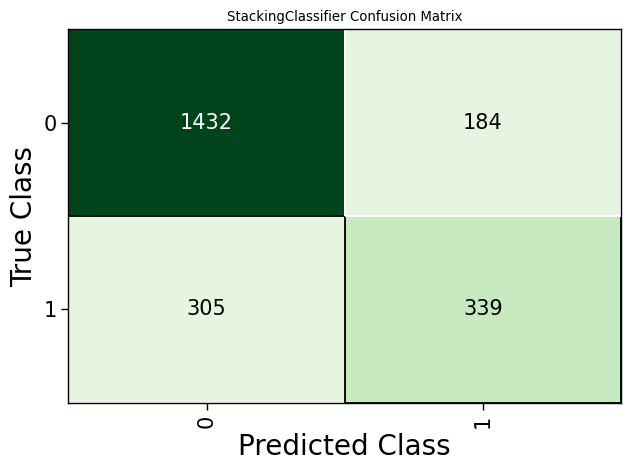

In [62]:
pyc.plot_model(tuned_radio_clf, plot='confusion_matrix')

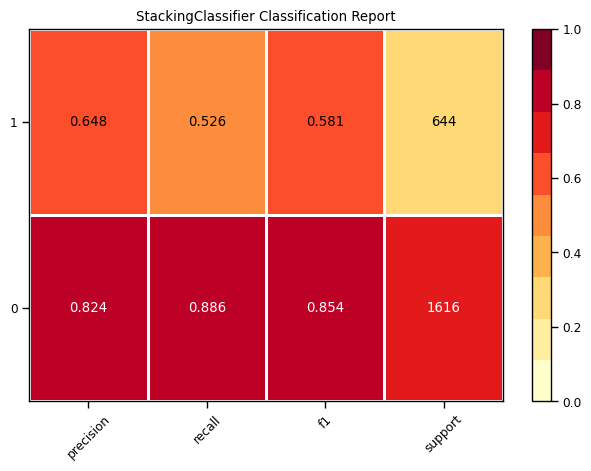

In [63]:
pyc.plot_model(tuned_radio_clf, plot='class_report')

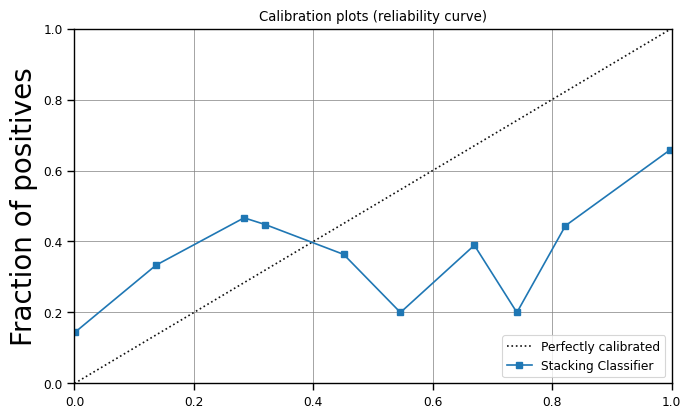

In [64]:
pyc.plot_model(tuned_radio_clf, plot='calibration')

In [79]:
# pyc.plot_model(tuned_radio_clf.estimators_[0], plot='feature_all')

In [65]:
pyc.plot_model(tuned_radio_clf.final_estimator_, plot='parameter')

,Parameters
nan_mode,Min
eval_metric,Logloss
iterations,77
sampling_frequency,PerTree
leaf_estimation_method,Newton
grow_policy,SymmetricTree
penalties_coefficient,1
boosting_type,Plain
model_shrink_mode,Constant
feature_border_type,GreedyLogSum


In [66]:
pyc.plot_model(tuned_radio_clf.final_estimator, plot='parameter')

,Parameters
depth,1
l2_leaf_reg,37
border_count,254
thread_count,12
verbose,False
random_strength,0.19282037282080944
task_type,CPU
n_estimators,77
random_state,42
eta,0.00015720888487783828


In [67]:
plt.rcParams.update(plt.rcParamsDefault)

In [75]:
pyc.predict_model(tuned_radio_clf, data=test_df, probability_threshold=gv.naive_radio_thresh,\
                  raw_score=True, round=10).loc[:, ['Score_0', 'Score_1']].describe()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Stacking Classifier,0.7836283186,0.7507566993,0.5263975155,0.6481835564,0.5809768638,0.4372429723,0.4415448745


,Score_0,Score_1
count,2260.000000,2260.000000
mean,0.502992,0.497008
std,0.002664,0.002664
min,0.498435,0.495248
25%,0.500415,0.495248
50%,0.504752,0.495248
75%,0.504752,0.499585
max,0.504752,0.501565


In [76]:
test_prediction_clf = pyc.predict_model(tuned_radio_clf, probability_threshold=gv.naive_radio_thresh, raw_score=True, round=10)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Stacking Classifier,0.7836283186,0.7507566993,0.5263975155,0.6481835564,0.5809768638,0.4372429723,0.4415448745


In [80]:
final_radio_clf = pyc.finalize_model(tuned_radio_clf)

In [83]:
pyc.predict_model(final_radio_clf, probability_threshold=gv.naive_radio_thresh,\
                  raw_score=True, round=10).loc[:, ['Score_0', 'Score_1']].describe()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Stacking Classifier,0.7836283186,0.7507566993,0.5263975155,0.6481835564,0.5809768638,0.4372429723,0.4415448745


,Score_0,Score_1
count,2260.000000,2260.000000
mean,0.502992,0.497008
std,0.002664,0.002664
min,0.498435,0.495248
25%,0.500415,0.495248
50%,0.504752,0.495248
75%,0.504752,0.499585
max,0.504752,0.501565


In [84]:
if save_model_flag:
    pyc.save_model(final_radio_clf, gv.models_path + gv.radio_model)  # Model (it will be saved with .pkl extension)

Transformation Pipeline and Model Successfully Saved


## Load Models

AGN detection model.

In [55]:
if load_model_flag:
    final_radio_clf = pyc.load_model(gv.models_path + gv.radio_model)

Transformation Pipeline and Model Successfully Loaded


### Prediction process

#### Feature importances

In [56]:
base_models_names = gf.get_base_estimators_names(final_radio_clf)
base_models       = gf.get_base_estimators_models(final_radio_clf)

In [57]:
print('Running data pre-processing:\n')
extended_data_radio_df = gf.preprocess_data(final_radio_clf, validation_df, base_models_names)

Running data pre-processing:



In [58]:
coef_sorted_meta_df = gf.feat_importances_meta_model(final_radio_clf, extended_data_radio_df)

In [59]:
coef_sorted_base_df = gf.feat_importances_base_models(base_models_names, base_models, extended_data_radio_df)

In [60]:
multicol_feat = [(key, name) for key in coef_sorted_base_df.keys() for name in ('Feature', 'Importance')]

In [61]:
print('Feature importances scaled to sum 100')
coef_sorted_base_df_copy_sum = coef_sorted_base_df.copy()
for key in coef_sorted_base_df_copy_sum.keys():
    print(f'Calculating for {key}...')
    coef_sorted_base_df_copy_sum[key].loc[:, 'Importance'] = coef_sorted_base_df[key].loc[:, 'Importance'] /\
                                                        coef_sorted_base_df[key].loc[:, 'Importance'].sum() * 100
    # display(coef_sorted_base_df_copy_sum[key])
coef_sorted_base_full_df = pd.concat([coef_sorted_base_df_copy_sum[key].reset_index(drop=True) for key in coef_sorted_base_df_copy_sum.keys()], axis=1)
coef_sorted_base_full_df.columns = pd.MultiIndex.from_tuples(multicol_feat)
display(coef_sorted_base_full_df)

Feature importances scaled to sum 100
Calculating for xgboost...
Calculating for rf...
Calculating for et...
Calculating for gbc...


xgboost                   rf                   et                  gbc  \
     Feature Importance   Feature Importance   Feature Importance   Feature   
0       K_W3  31.398144     W2_W3  11.975492     W2_W3  11.560197      K_W3   
1      W4mag  16.038353       y_J   9.755962       y_J   9.044376     W2_W3   
2      W2_W3   8.431828      K_W3   8.608330       g_r   7.682166       y_J   
3        y_J   4.795256       g_r   8.452798       r_z   7.201523       g_r   
4        g_r   4.120724       r_z   7.497715     W1_W2   6.971679       r_z   
5        r_z   3.708999     W1_W2   7.110812       r_i   6.918346     W4mag   
6      W1_W2   3.612973       r_i   7.099385      z_W1   6.673244     W1_W2   
7       z_W1   3.260767      z_W1   6.666517       i_y   6.575000      z_W1   
8        z_y   3.147870       i_z   6.437886       i_z   6.558140      y_W1   
9        r_i   3.010143       i_y   6.424662      K_W3   6.552412       r_i   
10  band_num   2.875560      y_W1   6.416028      y_W1   6.448079      K_W4   
11      K_W4   2.870731       z_y   6.232100       z_y   6.282232       i_y   
12       i_z   2.857941     W4mag   2.495318     W4mag   6.033796       z_y   
13      y_W1   2.811190  band_num   2.090265  band_num   3.081820       i_z   
14       i_y   2.699986      K_W4   1.290422      K_W4   1.044807       J_H   
15       H_K   2.194954       H_K   0.899164       H_K   0.761001  band_num   
16       J_H   2.164576       J_H   0.547143       J_H   0.611181       H_K   

               
   Importance  
0   50.346038  
1   16.248000  
2    7.430982  
3    7.218974  
4    5.321185  
5    4.074239  
6    2.810928  
7    1.339677  
8    1.295202  
9    1.051896  
10   0.809310  
11   0.603766  
12   0.546492  
13   0.396023  
14   0.218261  
15   0.195143  
16   0.093885

In [62]:
print('Feature importances scaled to sum 100')
coef_sorted_meta_df_copy_sum = coef_sorted_meta_df.copy()
coef_sorted_meta_df_copy_sum.loc[:, 'Importance'] = coef_sorted_meta_df.loc[:, 'Importance'] /\
                                                     coef_sorted_meta_df.loc[:, 'Importance'].sum() * 100
print('Meta model')
display(coef_sorted_meta_df_copy_sum)

Feature importances scaled to sum 100
Meta model


,Feature,Importance
0,xgboost,69.38605
1,et,30.61395
2,i_y,0.00000
3,rf,0.00000
4,band_num,0.00000
5,W4mag,0.00000
6,g_r,0.00000
7,r_i,0.00000
8,r_z,0.00000
9,i_z,0.00000


In [63]:
print('Combined feature importances scaled to sum 100')
coef_sorted_comb_sum = coef_sorted_meta_df_copy_sum.copy().set_index('Feature')
for key in coef_sorted_base_df_copy_sum.keys():
    factor = coef_sorted_meta_df_copy_sum.set_index('Feature').loc[key] / 100
    tmp_feat_imp = coef_sorted_base_full_df.loc[:, key].copy().set_index('Feature')
    coef_sorted_comb_sum = coef_sorted_comb_sum + tmp_feat_imp * factor
with pd.option_context('display.float_format', '{:.4f}'.format):
    display(coef_sorted_comb_sum.sort_values(by=['Importance'], ascending=False).drop(index=base_models_names))

Combined feature importances scaled to sum 100


,Importance
Feature,
K_W3,23.7919
W4mag,12.9756
W2_W3,9.3895
y_J,6.0961
g_r,5.2110
r_z,4.7782
W1_W2,4.6412
z_W1,4.3055
r_i,4.2066


Feature importances scaled to sum 100
--------------------
top features:
Feature	Importance
K_W3	23.792
W4mag	12.976
W2_W3	9.390
y_J	6.096
g_r	5.211
r_z	4.778
W1_W2	4.641
z_W1	4.305
r_i	4.207
z_y	4.107
i_z	3.991
y_W1	3.925
i_y	3.886
band_num	2.939
K_W4	2.312
H_K	1.756
J_H	1.689


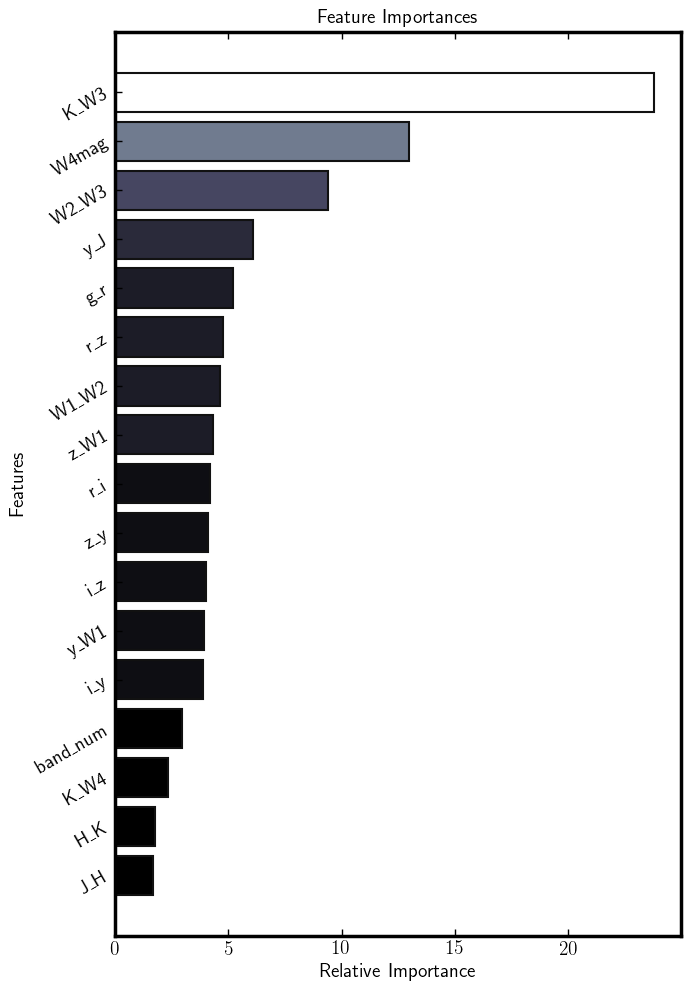

In [126]:
print('Feature importances scaled to sum 100')
try:
    fig         = plt.figure(figsize=(7,10))
    ax1         = fig.add_subplot(111)
    features_df = coef_sorted_comb_sum.sort_values(by=['Importance'], ascending=True).drop(index=base_models_names)
    features    = features_df.index.to_list()
    importances = features_df.loc[:, 'Importance'].to_list()
    import_scal_colors = (importances - np.nanmin(importances)) / (np.nanmax(importances) - np.nanmin(importances))
    ax1.set_title('Feature Importances', size=14)
    ax1.barh(range(len(importances)), importances,\
             color=plt.get_cmap('bone', len(importances))(import_scal_colors), align='center', ec='k', lw=1.5)
    plt.yticks(range(len(importances)), features)
    ax1.set_xlabel('Relative Importance', size=14)
    ax1.set_ylabel('Features', size=14)
    ax1.tick_params(axis='both', which='major', labelsize=14)
    ax1.tick_params(axis='y', which='major', rotation=30)
    plt.setp(ax1.spines.values(), linewidth=2.5)
    ax1.tick_params(which='both',top=True, right=False, direction='in')
    plt.tight_layout()
    if save_plot_flag:
        plt.savefig(gv.plots_path + 'feat_imp_classification_radio_detect_05.pdf', bbox_inches='tight')

    print('-' * 20)
    print('top features:')
    print('Feature\tImportance')
    for feat, imp in zip(reversed(features), reversed(importances)):
        print(f'{feat}\t{round(imp, 3):>.3f}')

except:
    print('learning algorithm does not provide feature importance.')

#### List optimised hyperparameters

In [65]:
hyperparams_models_df = gf.obtain_optimised_hyperpars(final_radio_clf, 'catboost', 'classification')
with pd.option_context('display.float_format', '{:.4f}'.format):
    display(hyperparams_models_df)

,catboost,xgboost,rf,et,gbc
learning_rate,0.0002,0.3000,NaN,NaN,0.1000
depth,1.0000,NaN,NaN,NaN,NaN
random_strength,0.1928,NaN,NaN,NaN,NaN
l2_leaf_reg,37.0000,NaN,NaN,NaN,NaN
n_estimators,NaN,100,100,100,100
subsample,NaN,1.0000,NaN,NaN,1.0000
max_depth,NaN,6.0000,NaN,NaN,3.0000
colsample_bytree,NaN,1.0000,NaN,NaN,NaN
min_child_weight,NaN,1.0000,NaN,NaN,NaN
reg_alpha,NaN,0.0000,NaN,NaN,NaN


---

In [66]:
print(f'Size of train set is {len(train_df):,}')
print(f'Size of test set is  {len(test_df):,}')

Size of train set is 18,081
Size of test set is  2,260


#### Calculate optimal threshold for classification

In [67]:
train_prediction_clf      = pyc.predict_model(final_radio_clf, data=train_df,       probability_threshold=gv.naive_radio_thresh, raw_score=True, round=10)
test_prediction_clf       = pyc.predict_model(final_radio_clf, data=test_df,        probability_threshold=gv.naive_radio_thresh, raw_score=True, round=10)
train_test_prediction_clf = pyc.predict_model(final_radio_clf, data=train_test_df,  probability_threshold=gv.naive_radio_thresh, raw_score=True, round=10)
calib_prediction_clf      = pyc.predict_model(final_radio_clf, data=calibration_df, probability_threshold=gv.naive_radio_thresh, raw_score=True, round=10)
validation_prediction_clf = pyc.predict_model(final_radio_clf, data=validation_df,  probability_threshold=gv.naive_radio_thresh, raw_score=True, round=10)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Stacking Classifier,0.8846855815,0.9427311714,0.6153419593,0.9987998800,0.7615235045,0.6910411739,0.7262957933


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Stacking Classifier,0.7836283186,0.7507566993,0.5263975155,0.6481835564,0.5809768638,0.4372429723,0.4415448745


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Stacking Classifier,0.8648289899,0.9048545866,0.5982740664,0.9188756856,0.7247003695,0.6403497365,0.6662406154


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Stacking Classifier,0.7871681416,0.7512947858,0.5292353823,0.6788461538,0.5947767481,0.4534475650,0.4599087366


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Stacking Classifier,0.7798230088,0.7432635639,0.4987639061,0.6508064516,0.5647305808,0.4208022045,0.4274745669


#### Naive threshold metrics.

In [68]:
cm_mat_train_naive      = gf.conf_mat_func(train_prediction_clf[target_feat],      train_prediction_clf['Label'])
cm_mat_test_naive       = gf.conf_mat_func(test_prediction_clf[target_feat],       test_prediction_clf['Label'])
cm_mat_train_test_naive = gf.conf_mat_func(train_test_prediction_clf[target_feat], train_test_prediction_clf['Label'])
cm_mat_calib_naive      = gf.conf_mat_func(calib_prediction_clf[target_feat],      calib_prediction_clf['Label'])
cm_mat_val_naive        = gf.conf_mat_func(validation_prediction_clf[target_feat], validation_prediction_clf['Label'])

In [69]:
naive_scores_df = gf.create_scores_df([cm_mat_train_naive, cm_mat_test_naive, cm_mat_train_test_naive, cm_mat_calib_naive, cm_mat_val_naive],\
                       ['Train', 'Test', 'Train+Test', 'Calibration', 'Validation'],\
                       ['F-\u03B2', 'MCC', 'Precision', 'Recall', 'ACC'])

In [70]:
with pd.option_context('display.float_format', '{:.4f}'.format):
    display(naive_scores_df.drop(columns=['ACC']))

,F-β,MCC,Precision,Recall
Train,0.7447,0.7263,0.9988,0.6153
Test,0.5753,0.4415,0.6482,0.5264
Train+Test,0.7104,0.6662,0.9189,0.5983
Calibration,0.5879,0.4599,0.6788,0.5292
Validation,0.5577,0.4275,0.6508,0.4988


#### Calibration curve

In [71]:
fract_positiv_train_test, mean_pred_val_train_test =\
                        calibration_curve(train_test_prediction_clf.loc[:, target_feat],\
                                          train_test_prediction_clf.loc[:, 'Score_1'],\
                                          n_bins=30, normalize=False, strategy='quantile')  # calibration_curve(y_test, prob_pos, n_bins=10)

fract_positiv_calib, mean_pred_val_calib =\
                        calibration_curve(calib_prediction_clf.loc[:, target_feat],\
                                          calib_prediction_clf.loc[:, 'Score_1'],\
                                          n_bins=30, normalize=False, strategy='quantile')  # calibration_curve(y_test, prob_pos, n_bins=10)

fract_positiv_val, mean_pred_val_val =\
                        calibration_curve(validation_prediction_clf.loc[:, target_feat],\
                                          validation_prediction_clf.loc[:, 'Score_1'],\
                                          n_bins=30, normalize=False, strategy='quantile')  # calibration_curve(y_test, prob_pos, n_bins=10)

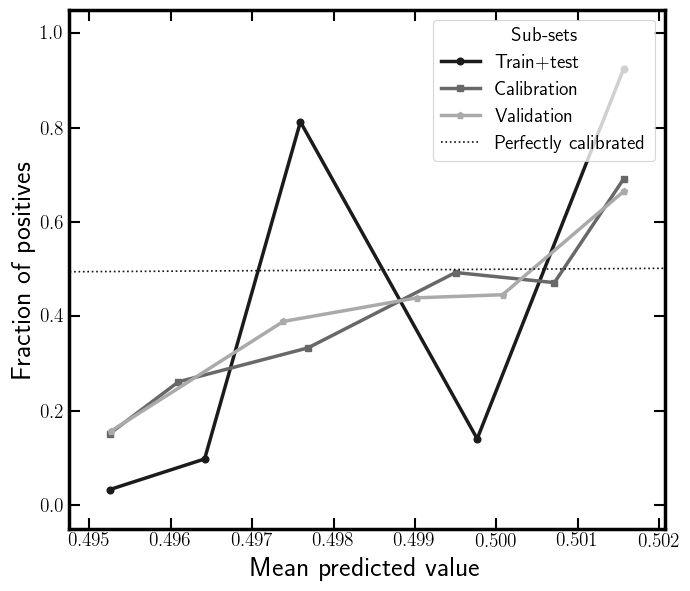

In [72]:
fig             = plt.figure(figsize=(7,6))
ax1             = fig.add_subplot(111)

min_x = np.nanmin([np.nanmin(train_test_prediction_clf.loc[:, 'Score_1']),\
                   np.nanmin(calib_prediction_clf.loc[:, 'Score_1']),\
                   np.nanmin(validation_prediction_clf.loc[:, 'Score_1'])])
max_x = np.nanmax([np.nanmax(train_test_prediction_clf.loc[:, 'Score_1']),\
                   np.nanmax(calib_prediction_clf.loc[:, 'Score_1']),\
                   np.nanmax(validation_prediction_clf.loc[:, 'Score_1'])])

ax1.plot(mean_pred_val_train_test, fract_positiv_train_test, ls='-',\
         marker='o', c=plt.get_cmap(gv.cmap_conf_matr)(1.0), lw=2.5, label='Train+test')
ax1.plot(mean_pred_val_calib, fract_positiv_calib, ls='-', marker='s',\
         c=plt.get_cmap(gv.cmap_conf_matr)(0.6), lw=2.5, label='Calibration')
ax1.plot(mean_pred_val_val, fract_positiv_val, ls='-', marker='p',\
         c=plt.get_cmap(gv.cmap_conf_matr)(0.3), lw=2.5, label='Validation')
ax1.plot([0, 1], [0, 1], ls=':', c='k', label='Perfectly calibrated')
ax1.set_xlabel('Mean predicted value', fontsize=20)
ax1.set_ylabel('Fraction of positives', fontsize=20)
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
plt.setp(ax1.spines.values(), linewidth=2.5)
plt.setp(ax1.spines.values(), linewidth=2.5)
ax1.set_xlim(left=min_x * 0.999, right=max_x * 1.001)
plt.legend(loc='best', fontsize=14, title='Sub-sets', title_fontsize=14)
fig.tight_layout()
if save_plot_flag:
    plt.savefig(gv.plots_path + 'calib_curves_pre_calib_radio.pdf', bbox_inches='tight')
plt.show()

#### Calculate optimal threshold for prediction

Calculate ROC AUC values and plots.

In [73]:
roc_auc_train      = roc_auc_score(train_prediction_clf.loc[:, target_feat],      train_prediction_clf.loc[:, 'Score_1'])
roc_auc_test       = roc_auc_score(test_prediction_clf.loc[:, target_feat],       test_prediction_clf.loc[:, 'Score_1'])
roc_auc_train_test = roc_auc_score(train_test_prediction_clf.loc[:, target_feat], train_test_prediction_clf.loc[:, 'Score_1'])
roc_auc_calib      = roc_auc_score(calib_prediction_clf.loc[:, target_feat],      calib_prediction_clf.loc[:, 'Score_1'])
roc_auc_validation = roc_auc_score(validation_prediction_clf.loc[:, target_feat], validation_prediction_clf.loc[:, 'Score_1'])

In [74]:
print(f'Area under the curve (ROC) for training   = {roc_auc_train:.5f}')
print(f'Area under the curve (ROC) for test       = {roc_auc_test:.5f}')
print(f'Area under the curve (ROC) for train+test = {roc_auc_train_test:.5f}')
print(f'Area under the curve (ROC) for calibraton = {roc_auc_calib:.5f}')
print(f'Area under the curve (ROC) for validation = {roc_auc_validation:.5f}')

Area under the curve (ROC) for training   = 0.94273
Area under the curve (ROC) for test       = 0.75076
Area under the curve (ROC) for train+test = 0.90485
Area under the curve (ROC) for calibraton = 0.75129
Area under the curve (ROC) for validation = 0.74326


In [75]:
fpr_train,      tpr_train,      thresh_train      = roc_curve(train_prediction_clf.loc[:, target_feat],      train_prediction_clf.loc[:, 'Score_1'])
fpr_test,       tpr_test,       thresh_test       = roc_curve(test_prediction_clf.loc[:, target_feat],       test_prediction_clf.loc[:, 'Score_1'])
fpr_train_test, tpr_train_test, thresh_train_test = roc_curve(train_test_prediction_clf.loc[:, target_feat], train_test_prediction_clf.loc[:, 'Score_1'])
fpr_calib,      tpr_calib,      thresh_calib      = roc_curve(calib_prediction_clf.loc[:, target_feat],      calib_prediction_clf.loc[:, 'Score_1'])
fpr_val,        tpr_val,        thresh_val        = roc_curve(validation_prediction_clf.loc[:, target_feat], validation_prediction_clf.loc[:, 'Score_1'])

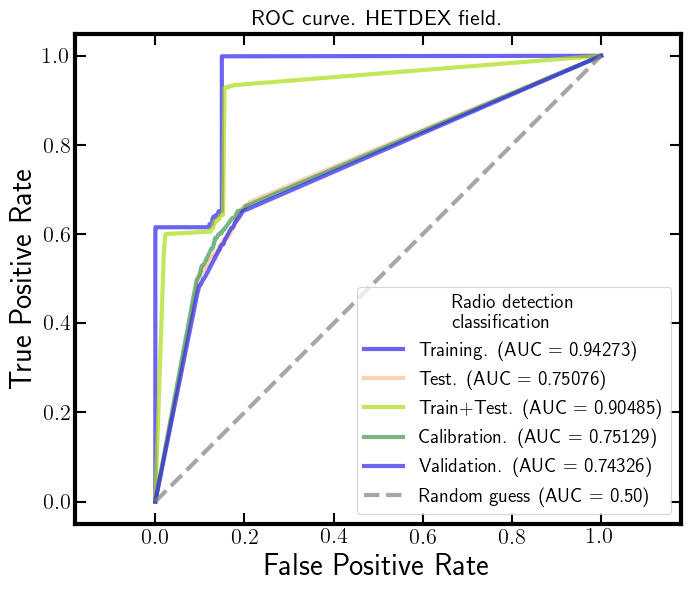

In [76]:
fig             = plt.figure(figsize=(7,6))
ax1             = fig.add_subplot(111)

viz_train       = RocCurveDisplay(fpr=fpr_train,      tpr=tpr_train,      roc_auc=roc_auc_train)
viz_test        = RocCurveDisplay(fpr=fpr_test,       tpr=tpr_test,       roc_auc=roc_auc_test)
viz_train_test  = RocCurveDisplay(fpr=fpr_train_test, tpr=tpr_train_test, roc_auc=roc_auc_train_test)
viz_calib       = RocCurveDisplay(fpr=fpr_calib,      tpr=tpr_calib,      roc_auc=roc_auc_calib)
viz_val         = RocCurveDisplay(fpr=fpr_val,        tpr=tpr_val,        roc_auc=roc_auc_validation)
viz_train.plot(ax=ax1,       lw=3, c=cm.get_cmap('cet_CET_C2s')(0.0), alpha=0.7, label=f"Training.    (AUC = {roc_auc_train:0.5f})")
viz_test.plot(ax=ax1,        lw=3, c=cm.get_cmap('cet_CET_C2s')(0.4), alpha=0.7, label=f"Test.        (AUC = {roc_auc_test:0.5f})")
viz_train_test.plot(ax=ax1,  lw=3, c=cm.get_cmap('cet_CET_C2s')(0.6), alpha=0.7, label=f"Train+Test.  (AUC = {roc_auc_train_test:0.5f})")
viz_calib.plot(ax=ax1,       lw=3, c=cm.get_cmap('cet_CET_C2s')(0.8), alpha=0.7, label=f"Calibration. (AUC = {roc_auc_calib:0.5f})")
viz_val.plot(ax=ax1,         lw=3, c=cm.get_cmap('cet_CET_C2s')(1.0), alpha=0.7, label=f"Validation.  (AUC = {roc_auc_validation:0.5f})")

ax1.plot([0, 1], [0, 1], ls='--', marker=None, c='Gray', alpha=0.7, lw=3.0, label='Random guess (AUC = 0.50)')

ax1.set_xlabel('False Positive Rate', fontsize=22)
ax1.set_ylabel('True Positive Rate', fontsize=22)
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=16)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
plt.setp(ax1.spines.values(), linewidth=3.0)
plt.setp(ax1.spines.values(), linewidth=3.0)
# ax1.set_aspect('equal', 'box')
plt.legend(loc=4, fontsize=14, title='Radio detection\nclassification', title_fontsize=14)
ax1.set_aspect('equal', 'datalim')
ax1.set_title('ROC curve. HETDEX field.', fontsize=16)
fig.tight_layout()
if save_plot_flag:
    plt.savefig(gv.plots_path + 'AUC_ROC_classification_radio_detect_05.pdf', bbox_inches='tight')
plt.show()

##### Obtain optimal thresholds from each sub-set

In [77]:
opt_thres_train      = thresh_train[np.argmax(tpr_train - fpr_train)]
opt_thres_test       = thresh_test[np.argmax(tpr_test - fpr_test)]
opt_thres_train_test = thresh_train_test[np.argmax(tpr_train_test - fpr_train_test)]
opt_thres_calib      = thresh_calib[np.argmax(tpr_calib - fpr_calib)]
opt_thres_validation = thresh_val[np.argmax(tpr_val - fpr_val)]

In [78]:
print(f'Optimal threshold from area under the curve (ROC) for training    = {opt_thres_train:.8e}')
print(f'Optimal threshold from area under the curve (ROC) for test        = {opt_thres_test:.8e}')
print(f'Optimal threshold from area under the curve (ROC) for train+test  = {opt_thres_train_test:.8e}')
print(f'Optimal threshold from area under the curve (ROC) for calibration = {opt_thres_calib:.8e}')
print(f'Optimal threshold from area under the curve (ROC) for validation  = {opt_thres_validation:.8e}')

Optimal threshold from area under the curve (ROC) for training    = 4.97228276e-01
Optimal threshold from area under the curve (ROC) for test        = 4.96057395e-01
Optimal threshold from area under the curve (ROC) for train+test  = 4.97228276e-01
Optimal threshold from area under the curve (ROC) for calibration = 4.95895450e-01
Optimal threshold from area under the curve (ROC) for validation  = 4.95329270e-01


##### Precision-Recall curve

In [79]:
prec_train,      recall_train,      thresh_train      = precision_recall_curve(train_prediction_clf.loc[:, target_feat],\
                                                                               train_prediction_clf.loc[:, 'Score_1'],      pos_label=1)
prec_test,       recall_test,       thresh_test       = precision_recall_curve(test_prediction_clf.loc[:, target_feat],\
                                                                               test_prediction_clf.loc[:, 'Score_1'],       pos_label=1)
prec_train_test, recall_train_test, thresh_train_test = precision_recall_curve(train_test_prediction_clf.loc[:, target_feat],\
                                                                               train_test_prediction_clf.loc[:, 'Score_1'], pos_label=1)
prec_calib,      recall_calib,      thresh_calib      = precision_recall_curve(calib_prediction_clf.loc[:, target_feat],\
                                                                               calib_prediction_clf.loc[:, 'Score_1'],      pos_label=1)
prec_validation, recall_validation, thresh_validation = precision_recall_curve(validation_prediction_clf.loc[:, target_feat],\
                                                                               validation_prediction_clf.loc[:, 'Score_1'], pos_label=1)

AUC for PR curve

In [80]:
auc_pr_train      = auc(recall_train,      prec_train)
auc_pr_test       = auc(recall_test,       prec_test)
auc_pr_train_test = auc(recall_train_test, prec_train_test)
auc_pr_calib      = auc(recall_calib,      prec_calib)
auc_pr_validation = auc(recall_validation, prec_validation)

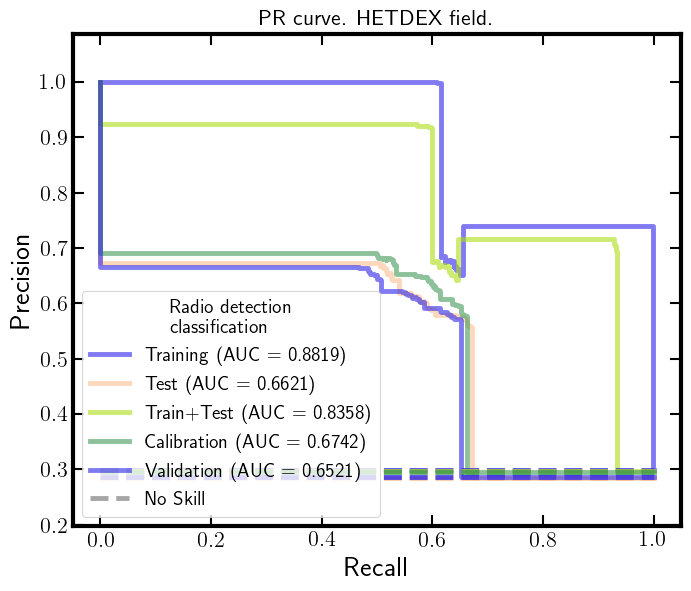

In [81]:
fig             = plt.figure(figsize=(7,6))
ax1             = fig.add_subplot(111)

viz_train       = PrecisionRecallDisplay(precision=prec_train,      recall=recall_train)
viz_test        = PrecisionRecallDisplay(precision=prec_test,       recall=recall_test)
viz_train_test  = PrecisionRecallDisplay(precision=prec_train_test, recall=recall_train_test)
viz_calib       = PrecisionRecallDisplay(precision=prec_calib,      recall=recall_calib)
viz_val         = PrecisionRecallDisplay(precision=prec_validation, recall=recall_validation)
viz_train.plot(ax=ax1,       lw=3.5, c=cm.get_cmap('cet_CET_C2s')(0.0), alpha=0.6, label=f"Training    (AUC = {auc_pr_train:.4f})")
viz_test.plot(ax=ax1,        lw=3.5, c=cm.get_cmap('cet_CET_C2s')(0.4), alpha=0.6, label=f"Test        (AUC = {auc_pr_test:.4f})")
viz_train_test.plot(ax=ax1,  lw=3.5, c=cm.get_cmap('cet_CET_C2s')(0.6), alpha=0.6, label=f"Train+Test  (AUC = {auc_pr_train_test:.4f})")
viz_calib.plot(ax=ax1,       lw=3.5, c=cm.get_cmap('cet_CET_C2s')(0.8), alpha=0.6, label=f"Calibration (AUC = {auc_pr_calib:.4f})")
viz_val.plot(ax=ax1,         lw=3.5, c=cm.get_cmap('cet_CET_C2s')(1.0), alpha=0.6, label=f"Validation  (AUC = {auc_pr_validation:.4f})")

no_skill_train      = np.sum(train_prediction_clf.loc[:, target_feat] == 1)      / len(train_prediction_clf.loc[:, target_feat])
no_skill_test       = np.sum(test_prediction_clf.loc[:, target_feat] == 1)       / len(test_prediction_clf.loc[:, target_feat])
no_skill_train_test = np.sum(train_test_prediction_clf.loc[:, target_feat] == 1) / len(train_test_prediction_clf.loc[:, target_feat])
no_skill_calib      = np.sum(calib_prediction_clf.loc[:, target_feat] == 1)      / len(calib_prediction_clf.loc[:, target_feat])
no_skill_val        = np.sum(validation_prediction_clf.loc[:, target_feat] == 1) / len(validation_prediction_clf.loc[:, target_feat])
ax1.plot([0, 1], [no_skill_train,      no_skill_train],      ls='--', marker=None, c=cm.get_cmap('cet_CET_C2s')(0.0), alpha=0.8, lw=3.5)
ax1.plot([0, 1], [no_skill_test,       no_skill_test],       ls='--', marker=None, c=cm.get_cmap('cet_CET_C2s')(0.4), alpha=0.8, lw=3.5)
ax1.plot([0, 1], [no_skill_train_test, no_skill_train_test], ls='--', marker=None, c=cm.get_cmap('cet_CET_C2s')(0.6), alpha=0.8, lw=3.5)
ax1.plot([0, 1], [no_skill_calib,      no_skill_calib],      ls='--', marker=None, c=cm.get_cmap('cet_CET_C2s')(0.8), alpha=0.8, lw=3.5)
ax1.plot([0, 1], [no_skill_val,        no_skill_val],        ls='--', marker=None, c=cm.get_cmap('cet_CET_C2s')(1.0), alpha=0.8, lw=3.5)
ax1.plot([1, 1], [1, 1], ls='--', marker=None, c='Gray', alpha=0.7, lw=3.5, label='No Skill', zorder=0)

ax1.set_xlabel('Recall', fontsize=20)
ax1.set_ylabel('Precision', fontsize=20)
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=16)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
plt.setp(ax1.spines.values(), linewidth=3.0)
plt.setp(ax1.spines.values(), linewidth=3.0)
# ax1.set_aspect('equal', 'box')
plt.legend(loc='best', fontsize=14, title='Radio detection\nclassification', title_fontsize=14)
ax1.set_aspect('equal', 'datalim')
ax1.set_title('PR curve. HETDEX field.', fontsize=16)
fig.tight_layout()
if save_plot_flag:
    plt.savefig(gv.plots_path + 'PR_curve_classification_radio_detect_05.pdf', bbox_inches='tight')
plt.show()

Find optimal threshold from PR curve

In [82]:
fscore_train      = (1 + gv.beta_F**2) * (prec_train      * recall_train)      / (prec_train * gv.beta_F**2      + recall_train)
fscore_test       = (1 + gv.beta_F**2) * (prec_test       * recall_test)       / (prec_test * gv.beta_F**2       + recall_test)
fscore_train_test = (1 + gv.beta_F**2) * (prec_train_test * recall_train_test) / (prec_train_test * gv.beta_F**2 + recall_train_test)
fscore_calib      = (1 + gv.beta_F**2) * (prec_calib      * recall_calib)      / (prec_calib * gv.beta_F**2      + recall_calib)
fscore_validation = (1 + gv.beta_F**2) * (prec_validation * recall_validation) / (prec_validation * gv.beta_F**2 + recall_validation)

In [83]:
opt_t_PR_train      = thresh_train[np.argmax(fscore_train)]
opt_t_PR_test       = thresh_test[np.argmax(fscore_test)]
opt_t_PR_train_test = thresh_train_test[np.argmax(fscore_train_test)]
opt_t_PR_calib      = thresh_calib[np.argmax(fscore_calib)]
opt_t_PR_validation = thresh_validation[np.argmax(fscore_validation)]

In [84]:
print(f'Optimal threshold from Precision-Recall curve for training    = {opt_t_PR_train:.8e}')
print(f'Optimal threshold from Precision-Recall curve for test        = {opt_t_PR_test:.8e}')
print(f'Optimal threshold from Precision-Recall curve for train+test  = {opt_t_PR_train_test:.8e}')
print(f'Optimal threshold from Precision-Recall curve for calibration = {opt_t_PR_calib:.8e}')
print(f'Optimal threshold from Precision-Recall curve for validation  = {opt_t_PR_validation:.8e}')

Optimal threshold from Precision-Recall curve for training    = 4.97228276e-01
Optimal threshold from Precision-Recall curve for test        = 4.96057395e-01
Optimal threshold from Precision-Recall curve for train+test  = 4.97228276e-01
Optimal threshold from Precision-Recall curve for calibration = 4.95895450e-01
Optimal threshold from Precision-Recall curve for validation  = 4.95328640e-01


In [85]:
print(f'The selected threshold, from train+test sub-set is {opt_t_PR_train_test:.5f}')
print(f'And, in its complete extension, is {opt_t_PR_train_test}')

The selected threshold, from train+test sub-set is 0.49723
And, in its complete extension, is 0.4972282762


---

In [86]:
radio_pred_threshold = float(opt_t_PR_train_test) # 4.97101925e-01

In [87]:
train_prediction_clf      = pyc.predict_model(final_radio_clf, data=train_df,       probability_threshold=radio_pred_threshold, raw_score=True, round=10)
test_prediction_clf       = pyc.predict_model(final_radio_clf, data=test_df,        probability_threshold=radio_pred_threshold, raw_score=True, round=10)
train_test_prediction_clf = pyc.predict_model(final_radio_clf, data=train_test_df,  probability_threshold=radio_pred_threshold, raw_score=True, round=10)
calib_prediction_clf      = pyc.predict_model(final_radio_clf, data=calibration_df, probability_threshold=radio_pred_threshold, raw_score=True, round=10)
validation_prediction_clf = pyc.predict_model(final_radio_clf, data=validation_df,  probability_threshold=radio_pred_threshold, raw_score=True, round=10)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Stacking Classifier,0.7923234334,0.9427311714,0.6554528651,0.6521979033,0.6538213331,0.5054916169,0.5054948124


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Stacking Classifier,0.7659292035,0.7507566993,0.6055900621,0.5864661654,0.5958747135,0.4311882083,0.4312981766


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Stacking Classifier,0.7880182293,0.9048545866,0.6464811784,0.6427514793,0.6446109339,0.4935771436,0.4935813376


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Stacking Classifier,0.7756637168,0.7512947858,0.6131934033,0.6215805471,0.6173584906,0.4586834019,0.4587045799


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Stacking Classifier,0.7704424779,0.7432635639,0.5846724351,0.6021642266,0.5932894324,0.4334315183,0.4335228977


Create confusion matrices.

In [88]:
cm_mat_train      = gf.conf_mat_func(train_prediction_clf[target_feat],      train_prediction_clf['Label'])
cm_mat_test       = gf.conf_mat_func(test_prediction_clf[target_feat],       test_prediction_clf['Label'])
cm_mat_train_test = gf.conf_mat_func(train_test_prediction_clf[target_feat], train_test_prediction_clf['Label'])
cm_mat_calib      = gf.conf_mat_func(calib_prediction_clf[target_feat],      calib_prediction_clf['Label'])
cm_mat_val        = gf.conf_mat_func(validation_prediction_clf[target_feat], validation_prediction_clf['Label'])

In [89]:
radio_scores_array_df = gf.create_scores_df([cm_mat_train, cm_mat_test, cm_mat_train_test, cm_mat_calib, cm_mat_val],\
                       ['Train', 'Test', 'Train+Test', 'Calibration', 'Validation'],\
                       ['F-\u03B2', 'MCC', 'Precision', 'Recall', 'ACC'])

In [90]:
with pd.option_context('display.float_format', '{:.4f}'.format):
    display(radio_scores_array_df.drop(columns=['ACC']))

,F-β,MCC,Precision,Recall
Train,0.6540,0.5055,0.6522,0.6555
Test,0.5968,0.4313,0.5865,0.6056
Train+Test,0.6448,0.4936,0.6428,0.6465
Calibration,0.6170,0.4587,0.6216,0.6132
Validation,0.5925,0.4335,0.6022,0.5847


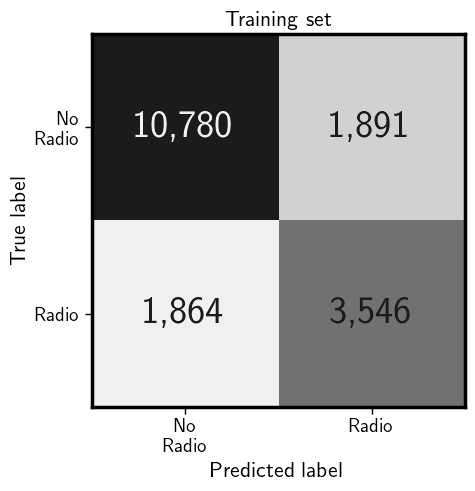

In [91]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)
_ = gf.plot_conf_mat(cm_mat_train, title='Training set', axin=ax1, display_labels=['No\nRadio', 'Radio'], log_stretch=False)
plt.tight_layout()
if save_plot_flag:
    plt.savefig(gv.plots_path + 'conf_matrix_train_classification_radio_detect_05.pdf', bbox_inches='tight')
plt.show()

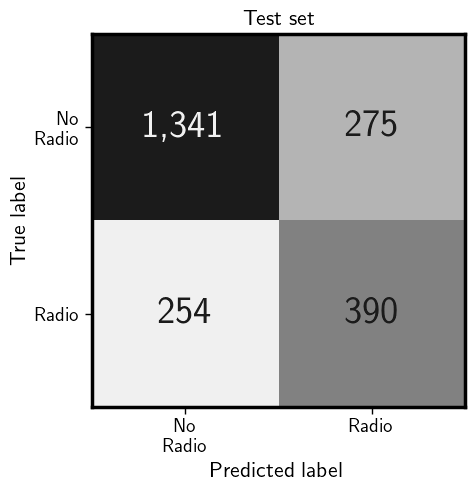

In [92]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)
_ = gf.plot_conf_mat(cm_mat_test, title='Test set', axin=ax1, display_labels=['No\nRadio', 'Radio'], log_stretch=False)
plt.tight_layout()
if save_plot_flag:
    plt.savefig(gv.plots_path + 'conf_matrix_test_classification_radio_detect_05.pdf', bbox_inches='tight')
plt.show()

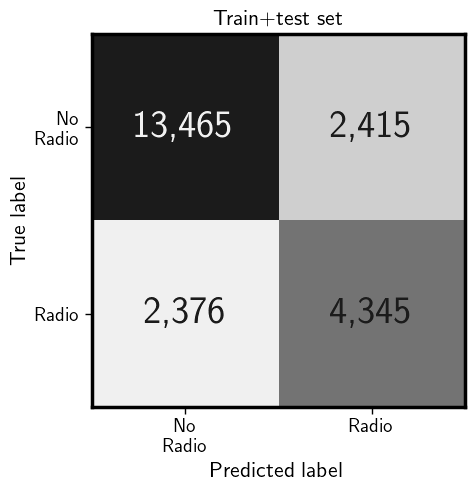

In [93]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)
_ = gf.plot_conf_mat(cm_mat_train_test, title='Train+test set', axin=ax1, display_labels=['No\nRadio', 'Radio'], log_stretch=False)
plt.tight_layout()
if save_plot_flag:
    plt.savefig(gv.plots_path + 'conf_matrix_train_test_classification_radio_detect_05.pdf', bbox_inches='tight')
plt.show()

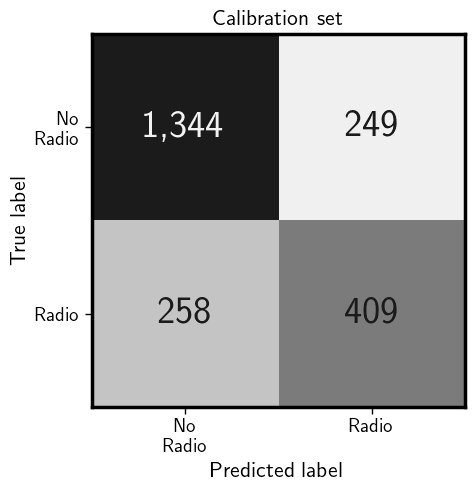

In [94]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)

_ = gf.plot_conf_mat(cm_mat_calib, title='Calibration set', axin=ax1, display_labels=['No\nRadio', 'Radio'], log_stretch=False)
plt.tight_layout()
if save_plot_flag:
    plt.savefig(gv.plots_path + 'conf_matrix_calibration_classification_radio_detect_05.pdf', bbox_inches='tight')
plt.show()

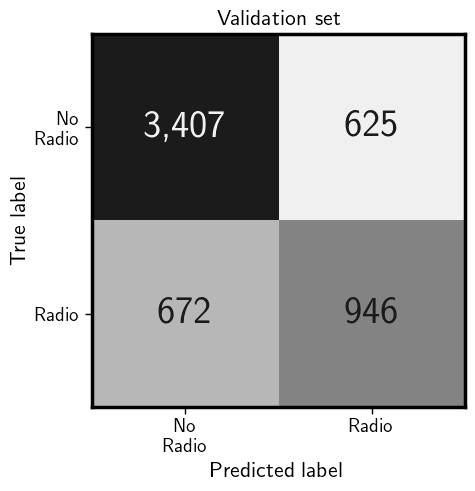

In [95]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)

_ = gf.plot_conf_mat(cm_mat_val, title='Validation set', axin=ax1, display_labels=['No\nRadio', 'Radio'], log_stretch=False)
plt.tight_layout()
if save_plot_flag:
    plt.savefig(gv.plots_path + 'conf_matrix_validation_classification_radio_detect_05.pdf', bbox_inches='tight')
plt.show()

### Calibrate model and save it separately

In [96]:
print('Running data pre-processing for calibration (train+test):\n')
extended_calibration_df = gf.preprocess_data(final_radio_clf, calibration_df, base_models_names)
initial_cols            = extended_calibration_df.columns.drop(base_models_names)

Running data pre-processing for calibration (train+test):



In [97]:
if save_model_flag:
    calibrated_final_radio_clf = BetaCalibration(parameters='abm')
    calibrated_final_radio_clf.fit(calib_prediction_clf.loc[:, 'Score_1'], calib_prediction_clf.loc[:, target_feat])
    dump(calibrated_final_radio_clf, gv.models_path + gv.cal_radio_model)

In [98]:
if load_model_flag:
    calibrated_final_radio_clf = load(gv.models_path + gv.cal_radio_model)

In [99]:
train_prediction_clf['Prob_radio']      = calibrated_final_radio_clf.predict(train_prediction_clf.loc[:, 'Score_1'])
test_prediction_clf['Prob_radio']       = calibrated_final_radio_clf.predict(test_prediction_clf.loc[:, 'Score_1'])
train_test_prediction_clf['Prob_radio'] = calibrated_final_radio_clf.predict(train_test_prediction_clf.loc[:, 'Score_1'])
calib_prediction_clf['Prob_radio']      = calibrated_final_radio_clf.predict(calib_prediction_clf.loc[:, 'Score_1'])
validation_prediction_clf['Prob_radio'] = calibrated_final_radio_clf.predict(validation_prediction_clf.loc[:, 'Score_1'])

In [100]:
train_prediction_clf['Label_cal_naive']      = np.array(train_prediction_clf.loc[:, 'Prob_radio']      >= gv.naive_radio_thresh).astype(int)
test_prediction_clf['Label_cal_naive']       = np.array(test_prediction_clf.loc[:, 'Prob_radio']       >= gv.naive_radio_thresh).astype(int)
train_test_prediction_clf['Label_cal_naive'] = np.array(train_test_prediction_clf.loc[:, 'Prob_radio'] >= gv.naive_radio_thresh).astype(int)
calib_prediction_clf['Label_cal_naive']      = np.array(calib_prediction_clf.loc[:, 'Prob_radio']      >= gv.naive_radio_thresh).astype(int)
validation_prediction_clf['Label_cal_naive'] = np.array(validation_prediction_clf.loc[:, 'Prob_radio'] >= gv.naive_radio_thresh).astype(int)

In [101]:
cm_mat_val_cal_naive        = gf.conf_mat_func(validation_prediction_clf[target_feat], validation_prediction_clf['Label_cal_naive'])
cm_mat_train_cal_naive      = gf.conf_mat_func(train_prediction_clf[target_feat],      train_prediction_clf['Label_cal_naive'])
cm_mat_test_cal_naive       = gf.conf_mat_func(test_prediction_clf[target_feat],       test_prediction_clf['Label_cal_naive'])
cm_mat_calib_cal_naive      = gf.conf_mat_func(calib_prediction_clf[target_feat],      calib_prediction_clf['Label_cal_naive'])
cm_mat_train_test_cal_naive = gf.conf_mat_func(train_test_prediction_clf[target_feat], train_test_prediction_clf['Label_cal_naive'])

In [102]:
radio_scores_cal_naive_df = gf.create_scores_df([cm_mat_train_cal_naive, cm_mat_test_cal_naive,\
                                              cm_mat_train_test_cal_naive, cm_mat_calib_cal_naive, cm_mat_val_cal_naive],\
                       ['Train', 'Test', 'Train+Test', 'Calibration', 'Validation'],\
                       ['F-\u03B2', 'MCC', 'Precision', 'Recall', 'ACC'])

In [103]:
with pd.option_context('display.float_format', '{:.4f}'.format):
    display(radio_scores_cal_naive_df.drop(columns=['ACC']))

,F-β,MCC,Precision,Recall
Train,0.7445,0.7258,0.9979,0.6153
Test,0.5816,0.4434,0.6409,0.5404
Train+Test,0.7107,0.6647,0.9143,0.6002
Calibration,0.5888,0.4563,0.6698,0.5352
Validation,0.5606,0.4254,0.6419,0.5074


##### Obtain optimal thresholds from train+test in calibrated model

##### Precision-Recall curve

In [104]:
prec_train_cal,      recall_train_cal,      thresh_train_cal      = precision_recall_curve(train_prediction_clf.loc[:, target_feat],\
                                                                               train_prediction_clf.loc[:, 'Prob_radio'],      pos_label=1)
prec_test_cal,       recall_test_cal,       thresh_test_cal       = precision_recall_curve(test_prediction_clf.loc[:, target_feat],\
                                                                               test_prediction_clf.loc[:, 'Prob_radio'],       pos_label=1)
prec_train_test_cal, recall_train_test_cal, thresh_train_test_cal = precision_recall_curve(train_test_prediction_clf.loc[:, target_feat],\
                                                                               train_test_prediction_clf.loc[:, 'Prob_radio'], pos_label=1)
prec_calib_cal,      recall_calib_cal,      thresh_calib_cal      = precision_recall_curve(calib_prediction_clf.loc[:, target_feat],\
                                                                               calib_prediction_clf.loc[:, 'Prob_radio'],      pos_label=1)
prec_validation_cal, recall_validation_cal, thresh_validation_cal = precision_recall_curve(validation_prediction_clf.loc[:, target_feat],\
                                                                               validation_prediction_clf.loc[:, 'Prob_radio'], pos_label=1)

AUC for PR curve

In [105]:
auc_pr_train_cal      = auc(recall_train_cal,      prec_train_cal)
auc_pr_test_cal       = auc(recall_test_cal,       prec_test_cal)
auc_pr_train_test_cal = auc(recall_train_test_cal, prec_train_test_cal)
auc_pr_calib_cal      = auc(recall_calib_cal,      prec_calib_cal)
auc_pr_validation_cal = auc(recall_validation_cal, prec_validation_cal)

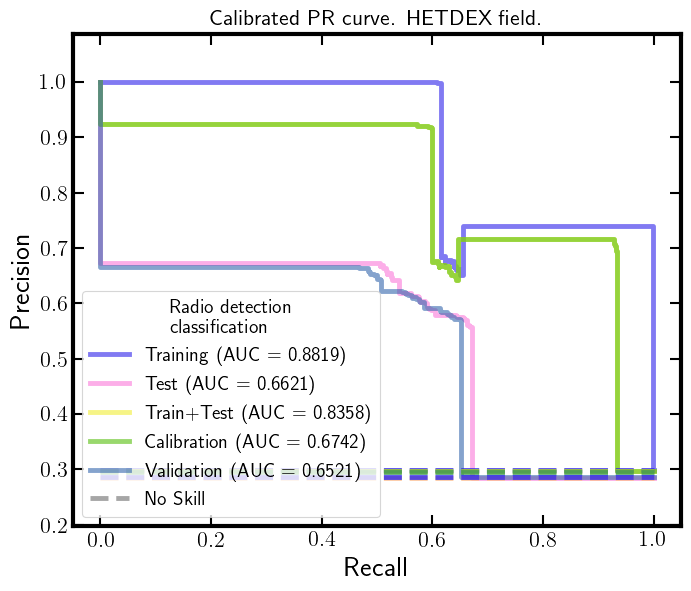

In [106]:
fig             = plt.figure(figsize=(7,6))
ax1             = fig.add_subplot(111)

viz_train       = PrecisionRecallDisplay(precision=prec_train_cal,      recall=recall_train_cal)
viz_test        = PrecisionRecallDisplay(precision=prec_test_cal,       recall=recall_test_cal)
viz_train_test  = PrecisionRecallDisplay(precision=prec_train_test_cal, recall=recall_train_test_cal)
viz_calib       = PrecisionRecallDisplay(precision=prec_train_test_cal, recall=recall_train_test_cal)
viz_val         = PrecisionRecallDisplay(precision=prec_validation_cal, recall=recall_validation_cal)
viz_train.plot(ax=ax1,       lw=3.5, c=cm.get_cmap('cet_CET_C2s')(0.0), alpha=0.6, label=f"Training    (AUC = {auc_pr_train_cal:.4f})")
viz_test.plot(ax=ax1,        lw=3.5, c=cm.get_cmap('cet_CET_C2s')(0.3), alpha=0.6, label=f"Test        (AUC = {auc_pr_test_cal:.4f})")
viz_train_test.plot(ax=ax1,  lw=3.5, c=cm.get_cmap('cet_CET_C2s')(0.5), alpha=0.6, label=f"Train+Test  (AUC = {auc_pr_train_test_cal:.4f})")
viz_calib.plot(ax=ax1,       lw=3.5, c=cm.get_cmap('cet_CET_C2s')(0.7), alpha=0.6, label=f"Calibration (AUC = {auc_pr_calib_cal:.4f})")
viz_val.plot(ax=ax1,         lw=3.5, c=cm.get_cmap('cet_CET_C2s')(0.9), alpha=0.6, label=f"Validation  (AUC = {auc_pr_validation_cal:.4f})")

no_skill_train      = np.sum(train_prediction_clf.loc[:, target_feat] == 1)      / len(train_prediction_clf.loc[:, target_feat])
no_skill_test       = np.sum(test_prediction_clf.loc[:, target_feat] == 1)       / len(test_prediction_clf.loc[:, target_feat])
no_skill_train_test = np.sum(train_test_prediction_clf.loc[:, target_feat] == 1) / len(train_test_prediction_clf.loc[:, target_feat])
no_skill_calib      = np.sum(calib_prediction_clf.loc[:, target_feat] == 1)      / len(calib_prediction_clf.loc[:, target_feat])
no_skill_val        = np.sum(validation_prediction_clf.loc[:, target_feat] == 1) / len(validation_prediction_clf.loc[:, target_feat])
ax1.plot([0, 1], [no_skill_train,      no_skill_train],      ls='--', marker=None, c=cm.get_cmap('cet_CET_C2s')(0.0), alpha=0.8, lw=3.5)
ax1.plot([0, 1], [no_skill_test,       no_skill_test],       ls='--', marker=None, c=cm.get_cmap('cet_CET_C2s')(0.4), alpha=0.8, lw=3.5)
ax1.plot([0, 1], [no_skill_train_test, no_skill_train_test], ls='--', marker=None, c=cm.get_cmap('cet_CET_C2s')(0.6), alpha=0.8, lw=3.5)
ax1.plot([0, 1], [no_skill_calib,      no_skill_calib],      ls='--', marker=None, c=cm.get_cmap('cet_CET_C2s')(0.8), alpha=0.8, lw=3.5)
ax1.plot([0, 1], [no_skill_val,        no_skill_val],        ls='--', marker=None, c=cm.get_cmap('cet_CET_C2s')(1.0), alpha=0.8, lw=3.5)
ax1.plot([1, 1], [1, 1], ls='--', marker=None, c='Gray', alpha=0.7, lw=3.5, label='No Skill', zorder=0)

ax1.set_xlabel('Recall', fontsize=20)
ax1.set_ylabel('Precision', fontsize=20)
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=16)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
plt.setp(ax1.spines.values(), linewidth=3.0)
plt.setp(ax1.spines.values(), linewidth=3.0)
# ax1.set_aspect('equal', 'box')
plt.legend(loc=3, fontsize=14, title='Radio detection\nclassification', title_fontsize=14)
ax1.set_aspect('equal', 'datalim')
ax1.set_title('Calibrated PR curve. HETDEX field.', fontsize=16)
fig.tight_layout()
if save_plot_flag:
    plt.savefig(gv.plots_path + 'PR_cal_curve_classification_radio_detect_05.pdf', bbox_inches='tight')
plt.show()

Find optimal threshold from PR curve

In [107]:
fscore_train_cal      = (1 + gv.beta_F**2) * (prec_train_cal      * recall_train_cal)      / (prec_train_cal * gv.beta_F**2      + recall_train_cal)
fscore_test_cal       = (1 + gv.beta_F**2) * (prec_test_cal       * recall_test_cal)       / (prec_test_cal * gv.beta_F**2       + recall_test_cal)
fscore_train_test_cal = (1 + gv.beta_F**2) * (prec_train_test_cal * recall_train_test_cal) / (prec_train_test_cal * gv.beta_F**2 + recall_train_test_cal)
fscore_calib_cal      = (1 + gv.beta_F**2) * (prec_calib_cal      * recall_calib_cal)      / (prec_calib_cal * gv.beta_F**2      + recall_calib_cal)
fscore_validation_cal = (1 + gv.beta_F**2) * (prec_validation_cal * recall_validation_cal) / (prec_validation_cal * gv.beta_F**2 + recall_validation_cal)

In [108]:
opt_t_PR_train_cal      = thresh_train_cal[np.argmax(fscore_train_cal)]
opt_t_PR_test_cal       = thresh_test_cal[np.argmax(fscore_test_cal)]
opt_t_PR_train_test_cal = thresh_train_test_cal[np.argmax(fscore_train_test_cal)]
opt_t_PR_calib_cal      = thresh_calib_cal[np.argmax(fscore_calib_cal)]
opt_t_PR_validation_cal = thresh_validation_cal[np.argmax(fscore_validation_cal)]

In [109]:
print('Otimal thresholds from calibrated Precision-Recal curves:')
print(f'Optimal threshold from Precision-Recall curve for training    = {opt_t_PR_train_cal:.5f}')
print(f'Optimal threshold from Precision-Recall curve for test        = {opt_t_PR_test_cal:.5f}')
print(f'Optimal threshold from Precision-Recall curve for train+test  = {opt_t_PR_train_test_cal:.5f}')
print(f'Optimal threshold from Precision-Recall curve for calibration = {opt_t_PR_calib_cal:.5f}')
print(f'Optimal threshold from Precision-Recall curve for validation  = {opt_t_PR_validation_cal:.5f}')

Otimal thresholds from calibrated Precision-Recal curves:
Optimal threshold from Precision-Recall curve for training    = 0.28230
Optimal threshold from Precision-Recall curve for test        = 0.19978
Optimal threshold from Precision-Recall curve for train+test  = 0.28230
Optimal threshold from Precision-Recall curve for calibration = 0.18992
Optimal threshold from Precision-Recall curve for validation  = 0.15834


In [110]:
print(f'The selected threshold, from calibration sub-set is {opt_t_PR_calib_cal:.5f}')
print(f'And, in its complete extension, is {opt_t_PR_calib_cal}')

The selected threshold, from calibration sub-set is 0.18992
And, in its complete extension, is 0.18991847427666925


In [111]:
train_prediction_clf['Label_cal']      = np.array(train_prediction_clf.loc[:, 'Prob_radio']      >= opt_t_PR_calib_cal).astype(int)
test_prediction_clf['Label_cal']       = np.array(test_prediction_clf.loc[:, 'Prob_radio']       >= opt_t_PR_calib_cal).astype(int)
train_test_prediction_clf['Label_cal'] = np.array(train_test_prediction_clf.loc[:, 'Prob_radio'] >= opt_t_PR_calib_cal).astype(int)
calib_prediction_clf['Label_cal']      = np.array(calib_prediction_clf.loc[:, 'Prob_radio']      >= opt_t_PR_calib_cal).astype(int)
validation_prediction_clf['Label_cal'] = np.array(validation_prediction_clf.loc[:, 'Prob_radio'] >= opt_t_PR_calib_cal).astype(int)

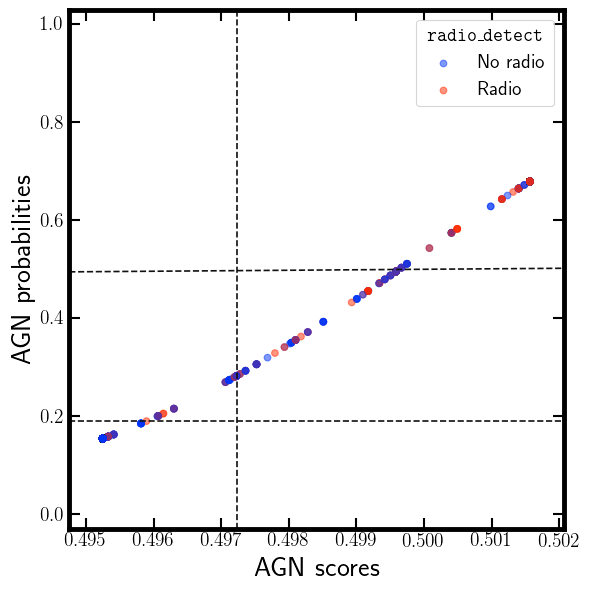

In [112]:
fig             = plt.figure(figsize=(6,6))
ax1             = fig.add_subplot(111, xscale='linear', yscale='linear')

set_to_plot     = calib_prediction_clf

ax1.scatter(set_to_plot.loc[:, 'Score_1'], set_to_plot.loc[:, 'Prob_radio'], marker='o',\
            alpha=0.5, c=set_to_plot.loc[:, target_feat],\
            cmap=plt.get_cmap('cet_rainbow',len(np.unique(set_to_plot.loc[:, target_feat]))))
ax1.axline([0,0], [1,1], color='k', ls='dashed')
ax1.axhline(y=opt_t_PR_calib_cal, color='k', ls='dashed')
ax1.axvline(x=opt_t_PR_train_test, color='k', ls='dashed')

ax1.scatter([-1.], [-1.], marker='o', alpha=0.5, label='No radio',\
            color=plt.get_cmap('cet_rainbow',len(np.unique(set_to_plot.loc[:, target_feat])))(0.0))
ax1.scatter([-1.], [-1.], marker='o', alpha=0.5, label='Radio',\
            color=plt.get_cmap('cet_rainbow',len(np.unique(set_to_plot.loc[:, target_feat])))(1.0))

ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.set_xlabel('AGN scores', size=20)
ax1.set_ylabel('AGN probabilities', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
ax1.legend(loc='best', fontsize=14, title='$\mathtt{radio\_detect}$', title_fontsize=14)
ax1.set_xlim(left=set_to_plot.loc[:, 'Score_1'].min() * 0.999, right=set_to_plot.loc[:, 'Score_1'].max() * 1.001)
ax1.set_ylim(bottom=-0.03, top=1.03)
fig.tight_layout()
plt.show()

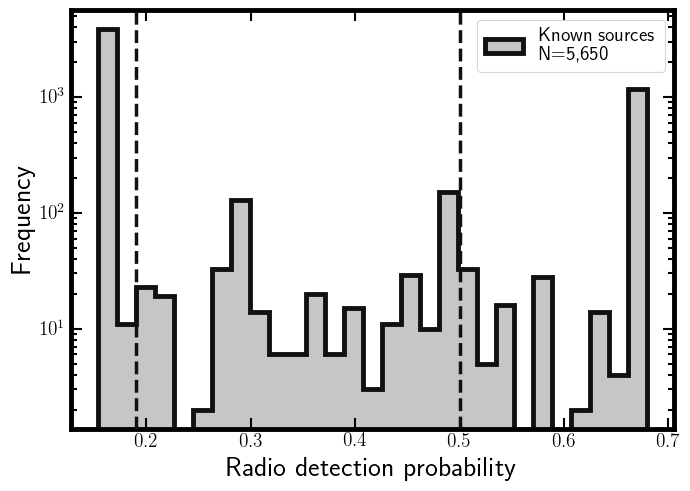

In [113]:
fig             = plt.figure(figsize=(7,5.0))
ax1             = fig.add_subplot(111, xscale='linear', yscale='log')

set_to_plot     = validation_prediction_clf

min_score  = np.nanmin(set_to_plot.loc[:, 'Prob_radio'])
max_score  = np.nanmax(set_to_plot.loc[:, 'Prob_radio'])
score_bins = np.linspace(min_score, max_score, 30)

sample_size = len(set_to_plot.loc[:, 'Prob_radio'])

ax1.hist(set_to_plot.loc[:, 'Prob_radio'], bins=score_bins, histtype='stepfilled', ec='k',\
         lw=3.5, color=cm.get_cmap('cet_gray')(0.8), alpha=1.0, label=f'Known sources\nN={sample_size:,}')

ax1.axvline(x=0.5, ls='--', c='k', lw=2.5)
ax1.axvline(x=opt_t_PR_calib_cal, ls='--', c='k', lw=2.5, zorder=10)
    
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.set_xlabel('Radio detection probability', size=20)
ax1.set_ylabel('Frequency', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.legend(loc=1, fontsize=14)
plt.grid(False)
#ax1.set_aspect('equal', 'box')
fig.tight_layout()
if save_plot_flag:
    plt.savefig(gv.plots_path + 'hist_predicted_radio_cal_scores_pred_AGN_known.pdf', bbox_inches='tight')
plt.show()

#### Calibration curve

In [114]:
fract_positiv_train_test_cal, mean_pred_val_train_test_cal =\
                        calibration_curve(train_test_prediction_clf.loc[:, target_feat],\
                                          train_test_prediction_clf.loc[:, 'Prob_radio'],\
                                          n_bins=30, normalize=False, strategy='quantile')  # calibration_curve(y_test, prob_pos, n_bins=10)

fract_positiv_calib_cal, mean_pred_val_calib_cal =\
                        calibration_curve(calib_prediction_clf.loc[:, target_feat],\
                                          calib_prediction_clf.loc[:, 'Prob_radio'],\
                                          n_bins=30, normalize=False, strategy='quantile')  # calibration_curve(y_test, prob_pos, n_bins=10)

fract_positiv_val_cal, mean_pred_val_val_cal =\
                        calibration_curve(validation_prediction_clf.loc[:, target_feat],\
                                          validation_prediction_clf.loc[:, 'Prob_radio'],\
                                          n_bins=30, normalize=False, strategy='quantile')  # calibration_curve(y_test, prob_pos, n_bins=10)

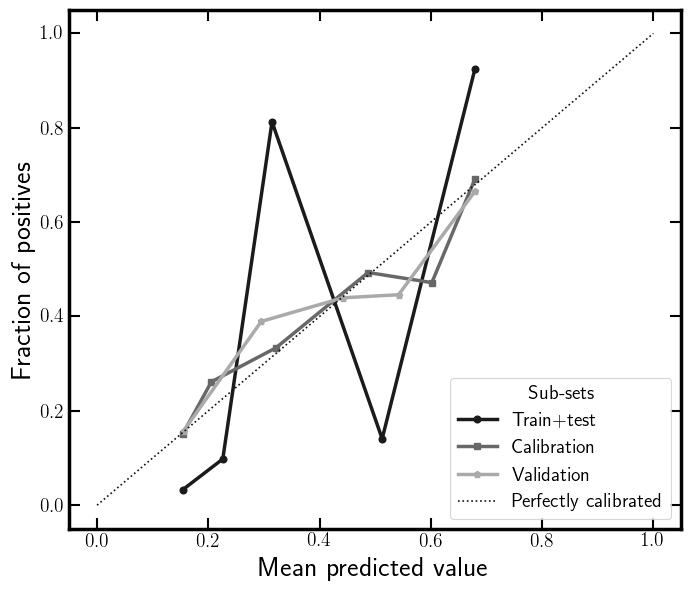

In [115]:
fig             = plt.figure(figsize=(7,6))
ax1             = fig.add_subplot(111)

ax1.plot(mean_pred_val_train_test_cal, fract_positiv_train_test_cal, ls='-',\
         marker='o', c=plt.get_cmap(gv.cmap_conf_matr)(1.0), lw=2.5, label='Train+test')
ax1.plot(mean_pred_val_calib_cal, fract_positiv_calib_cal, ls='-', marker='s',\
         c=plt.get_cmap(gv.cmap_conf_matr)(0.6), lw=2.5, label='Calibration')
ax1.plot(mean_pred_val_val_cal, fract_positiv_val_cal, ls='-', marker='p',\
         c=plt.get_cmap(gv.cmap_conf_matr)(0.3), lw=2.5, label='Validation')
ax1.plot([0, 1], [0, 1], ls=':', c='k', label='Perfectly calibrated')
ax1.set_xlabel('Mean predicted value', fontsize=20)
ax1.set_ylabel('Fraction of positives', fontsize=20)
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
plt.setp(ax1.spines.values(), linewidth=2.5)
plt.setp(ax1.spines.values(), linewidth=2.5)
plt.legend(loc='best', fontsize=14, title='Sub-sets', title_fontsize=14)
fig.tight_layout()
if save_plot_flag:
    plt.savefig(gv.plots_path + 'calib_curves_post_calib_radio.pdf', bbox_inches='tight')
plt.show()

### Check if calibration was useful

Brier score is used for this. And, in particular, Brier Skill Score (BSS).  
Its values can be in the range $[0, 1]$

If BSS $\ll 0$, calibration was not succesful. If BSS $\approx 0$, it performs as the previous model.  
If BSS $\gg 0$, calibration is useful and performs better than original model.

In [116]:
BS_ref = brier_score_loss(validation_prediction_clf.loc[:, target_feat], validation_prediction_clf.loc[:, 'Label'],     pos_label=1)
BS     = brier_score_loss(validation_prediction_clf.loc[:, target_feat], validation_prediction_clf.loc[:, 'Label_cal'], pos_label=1)
BSS    = 1 - (BS/BS_ref)

In [117]:
print(f'Brier Skill Score is {BSS:.3f} using the validation set.')

Brier Skill Score is -0.029 using the validation set.


Create confusion matrices.

In [118]:
cm_mat_val_cal        = gf.conf_mat_func(validation_prediction_clf[target_feat], validation_prediction_clf['Label_cal'])
cm_mat_train_cal      = gf.conf_mat_func(train_prediction_clf[target_feat],      train_prediction_clf['Label_cal'])
cm_mat_test_cal       = gf.conf_mat_func(test_prediction_clf[target_feat],       test_prediction_clf['Label_cal'])
cm_mat_calib_cal      = gf.conf_mat_func(calib_prediction_clf[target_feat],      calib_prediction_clf['Label_cal'])
cm_mat_train_test_cal = gf.conf_mat_func(train_test_prediction_clf[target_feat], train_test_prediction_clf['Label_cal'])

In [119]:
radio_scores_cal_df = gf.create_scores_df([cm_mat_train_cal, cm_mat_test_cal,\
                                              cm_mat_train_test_cal, cm_mat_calib_cal, cm_mat_val_cal],\
                       ['Train', 'Test', 'Train+Test', 'Calibration', 'Validation'],\
                       ['F-\u03B2', 'MCC', 'Precision', 'Recall', 'ACC'])

In [120]:
with pd.option_context('display.float_format', '{:.4f}'.format):
    display(radio_scores_cal_df.drop(columns=['ACC']))

,F-β,MCC,Precision,Recall
Train,0.8520,0.7771,0.7232,0.9989
Test,0.6175,0.4447,0.5701,0.6630
Train+Test,0.8106,0.7133,0.7000,0.9323
Calibration,0.6250,0.4547,0.5951,0.6522
Validation,0.6068,0.4372,0.5805,0.6304


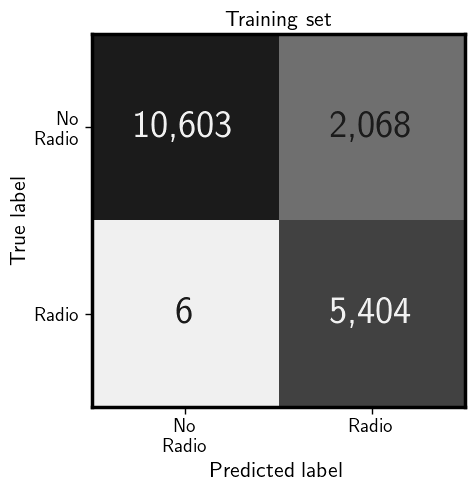

In [121]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)
_ = gf.plot_conf_mat(cm_mat_train_cal, title='Training set', axin=ax1, display_labels=['No\nRadio', 'Radio'], log_stretch=False)
if save_plot_flag:
    plt.savefig(gv.plots_path + 'conf_matrix_train_classification_radio_detect_cal.pdf', bbox_inches='tight')
plt.show()

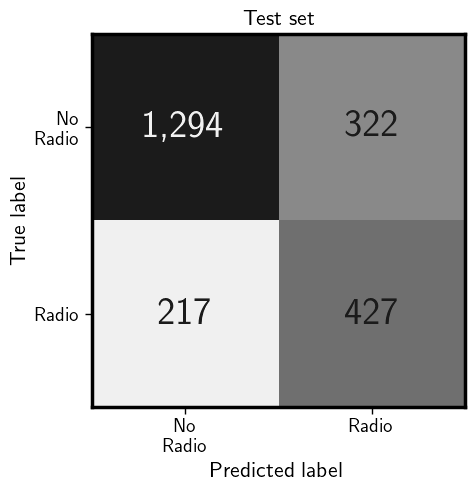

In [122]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)
_ = gf.plot_conf_mat(cm_mat_test_cal, title='Test set', axin=ax1, display_labels=['No\nRadio', 'Radio'], log_stretch=False)
if save_plot_flag:
    plt.savefig(gv.plots_path + 'conf_matrix_test_classification_radio_detect_cal.pdf', bbox_inches='tight')
plt.show()

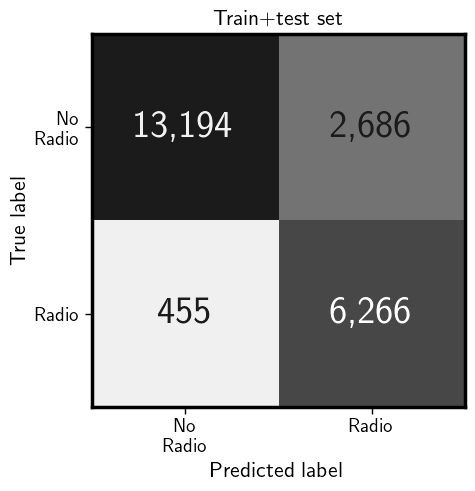

In [123]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)
ax1 = gf.plot_conf_mat(cm_mat_train_test_cal, title='Train+test set', axin=ax1, display_labels=['No\nRadio', 'Radio'], log_stretch=False)
ax1.texts[3].set_color('white')
if save_plot_flag:
    plt.savefig(gv.plots_path + 'conf_matrix_train_test_classification_radio_detect_cal.pdf', bbox_inches='tight')
plt.show()

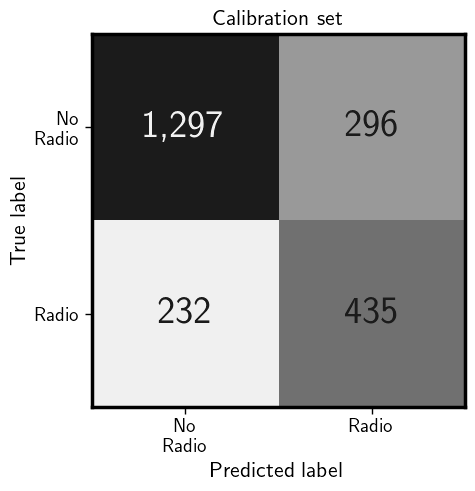

In [124]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)

_ = gf.plot_conf_mat(cm_mat_calib_cal, title='Calibration set', axin=ax1, display_labels=['No\nRadio', 'Radio'], log_stretch=False)
if save_plot_flag:
    plt.savefig(gv.plots_path + 'conf_matrix_calibration_classification_radio_detect_cal.pdf', bbox_inches='tight')
plt.show()

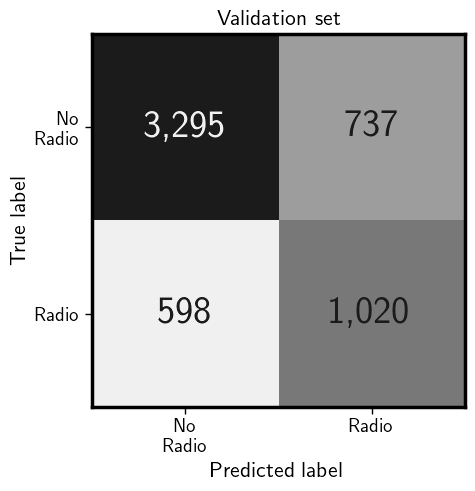

In [125]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)

_ = gf.plot_conf_mat(cm_mat_val_cal, title='Validation set', axin=ax1, display_labels=['No\nRadio', 'Radio'], log_stretch=False)
if save_plot_flag:
    plt.savefig(gv.plots_path + 'conf_matrix_validation_classification_radio_detect_cal.pdf', bbox_inches='tight')
plt.show()